In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import contract_18_decimals_to_float

import warnings
warnings.filterwarnings('ignore')

In [3]:
tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

In [4]:
def liquidity_maker_individual_flow(liquidity_df: pd.DataFrame, position_changes_df: pd.DataFrame,
                                   maker: str, pool_name: str, xsize: int=15, ysize: int=14):
    maker_pool_liquidity_df = liquidity_df[(liquidity_df["pool_name"] == pool_name) &
                            (liquidity_df["maker"] == maker)]
    lower_bound_median = maker_pool_liquidity_df["lower_bound"].median()
    lower_bound_std = maker_pool_liquidity_df["lower_bound"].std()
    upper_bound_median = maker_pool_liquidity_df["upper_bound"].median()
    upper_bound_std = maker_pool_liquidity_df["upper_bound"].std()
    maker_pool_liquidity_df = maker_pool_liquidity_df[
        (maker_pool_liquidity_df["lower_bound"] > (lower_bound_median - 2 * lower_bound_std)) &
        (maker_pool_liquidity_df["upper_bound"] < (upper_bound_median + 2 * upper_bound_std))
    ]

    filtered_position_changes_df = position_changes_df[position_changes_df["pool_name"] == pool_name]
    price_median = filtered_position_changes_df["swapped_price"].median()
    price_std = filtered_position_changes_df["swapped_price"].std()
    filtered_position_changes_df = filtered_position_changes_df[
        (filtered_position_changes_df["swapped_price"] > (price_median - 2 * price_std)) &
        (filtered_position_changes_df["swapped_price"] < (price_median + 2 * price_std))
    ]

    #   bounds respective to the price
    fig = plt.figure(figsize=(15, 14))
    ax = fig.add_subplot(4, 1, 1)
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["lower_bound"], 
            color='r', label='lower bound')
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["upper_bound"], 
            color='g', label='upper bound')
    ax.plot(maker_pool_liquidity_df["time"], 
            (maker_pool_liquidity_df["upper_bound"] + maker_pool_liquidity_df["lower_bound"]) / 2, 
            color='b', linestyle='--', label='central bound')
    ax.plot(filtered_position_changes_df[
                (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
            ]["time"],
           filtered_position_changes_df[
                (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
            ]["swapped_price"],
           color='orange', label="swap price")
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.legend()
    ax.grid()
    ax.set_title("Bounds estimated by " + maker + " for " + pool_name + " respective to the price for this token")

    #   fees and operations count distributions
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["quote_fee"], color='r',
            label='collected fees')

    ax2 = ax.twinx()
    count_changes_df = (pd.to_datetime(
        filtered_position_changes_df[
                (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
        ]['time']
    ).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))
    count_changes_df.sort_values("date", inplace=True)
    ax2.plot(count_changes_df["date"], count_changes_df["count"], color='g', linestyle='--', label='count of swaps')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax2.set_ylabel("operations count")
    ax.grid()
    ax.set_title("Collected fees and count of operations in " + pool_name +" by " + maker)

    # demonstration of the provided and extracted liquidities
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] >= 0]["time"],
           maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] >= 0]["fixed_liquidity"],
           color='g', label='investments')
    ax.plot(maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] < 0]["time"],
           maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] < 0]["fixed_liquidity"],
           color='r', label='extractions')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.set_title("Provided and extracted liquidities from the " + pool_name + " by " + maker)
    ax.grid(True, linestyle='--')

    #   liquidity balance
    ax = fig.add_subplot(4, 1, 4)
    maker_pool_liquidity_df["liquidity_balance"] = maker_pool_liquidity_df["fixed_liquidity"].cumsum()
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["liquidity_balance"],
           color='b', label='balance')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.set_title("Balance of the provided liquidity to the " + pool_name + " by " + maker)
    ax.grid(True, linestyle='--')
    fig.tight_layout()
    plt.show()

# Preloading required tables

In [5]:
liquidity_changes_df = pd.read_csv("liquidity_changes.csv")
liquidity_changes_df["time"] = pd.to_datetime(liquidity_changes_df["timestamp"], unit='s')
liquidity_changes_df["day_of_year"] = liquidity_changes_df["time"].dt.dayofyear
liquidity_changes_df["pool_name"] = liquidity_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
liquidity_changes_df.drop(columns=["base_token", "tx_hash", "from_function_signature"], inplace=True)
liquidity_changes_df["lower_bound"] = pow(1.0001, liquidity_changes_df["lower_tick"])
liquidity_changes_df["upper_bound"] = pow(1.0001, liquidity_changes_df["upper_tick"])
liquidity_changes_df["fixed_liquidity"] = [contract_18_decimals_to_float(liquidity_record) for 
                                           liquidity_record in liquidity_changes_df["liquidity"]]
liquidity_changes_df.drop(columns=["Unnamed: 0", "quote_token", "lower_tick", "upper_tick", "liquidity", "block_number"], 
                          inplace=True)
liquidity_changes_df["central_bound"] = (liquidity_changes_df["upper_bound"] + liquidity_changes_df["lower_bound"]) / 2
liquidity_changes_df

id  \
0      0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
1      0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2      0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3      0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
4      0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...   
...                                                  ...   
95645  0x3c94355621ea01688d374d07da032f57f3ec04480187...   
95646  0x19a82695df86a912368aac959536f93262c39cfe02f6...   
95647  0xda223d45899d4d3e9e39a193dbbda700edde88110101...   
95648  0x716065511888b305590bf64cb26fba2f2270d26453c8...   
95649  0xbf552e4e88fe8ab2d65f459461336b3bd2874248529e...   

                                            maker           base  \
0      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7      46.254982   
1      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7       0.012181   
2      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7       3.572179   
3      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7       0.000921   
4      0x35952141922ee99a04e016c967c3f0ad589ea958       0.100000   
...                                           ...            ...   
95645  0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd   -2470.572327   
95646  0xe77dd81813bd06d74a30d1b2c07418906456498e -204626.160511   
95647  0xe77dd81813bd06d74a30d1b2c07418906456498e   49063.646978   
95648  0x70332de459d5554a9a310a7c4f7c6069c73604f9  487306.142879   
95649  0x70332de459d5554a9a310a7c4f7c6069c73604f9 -549233.832985   

               quote   quote_fee  block_number_log_index   timestamp  \
0      200000.000000    0.000000               515557003  1638000985   
1          50.000000    0.000000               515554004  1638000985   
2      200000.000000    0.000000               515555003  1638000985   
3          50.000000    0.000000               515552004  1638000985   
4         472.798469    0.000000               516478004  1638003992   
...              ...         ...                     ...         ...   
95645 -248190.110460    0.000000              6654324008  1651142059   
95646 -454278.053108   58.114949              6654380006  1651142170   
95647  123088.079928    0.000000              6654370006  1651142170   
95648  500000.000000    0.000000              6654565006  1651142607   
95649 -441083.889544  151.659824              6654568006  1651142607   

                     time  day_of_year pool_name   lower_bound   upper_bound  \
0     2021-11-27 08:16:25          331      vETH  3.895536e+03  4.313830e+03   
1     2021-11-27 08:16:25          331      vETH  2.954278e-39  3.384921e+38   
2     2021-11-27 08:16:25          331      vBTC  5.171263e+04  5.692287e+04   
3     2021-11-27 08:16:25          331      vBTC  2.954278e-39  3.384921e+38   
4     2021-11-27 09:06:32          331      vETH  3.990155e+03  4.288026e+03   
...                   ...          ...       ...           ...           ...   
95645 2022-04-28 10:34:19          118      vSOL  9.108329e+01  1.103619e+02   
95646 2022-04-28 10:36:10          118     vSAND  2.330208e+00  2.823418e+00   
95647 2022-04-28 10:36:10          118     vSAND  2.316270e+00  2.806529e+00   
95648 2022-04-28 10:43:27          118      vFTM  9.084684e-01  1.100754e+00   
95649 2022-04-28 10:43:27          118      vFTM  9.194351e-01  1.114042e+00   

       fixed_liquidity  central_bound  
0         1.208513e+05   4.104683e+03  
1         7.804067e-01   1.692461e+38  
2         3.564884e+04   5.431775e+04  
3         2.145790e-01   1.692461e+38  
4         3.863152e+02   4.139091e+03  
...                ...            ...  
95645    -5.283875e+05   1.007226e+02  
95646    -6.522008e+06   2.576813e+00  
95647     1.658299e+06   2.561399e+00  
95648     1.053371e+07   1.004611e+00  
95649    -1.056971e+07   1.016738e+00  

[95650 rows x 14 columns]

In [6]:
makers_df = pd.read_csv("makers.csv")
makers_df.drop(columns=["Unnamed: 0"], inplace=True)
makers_df["time"] = pd.to_datetime(makers_df["timestamp"], unit='s')
makers_df

id  collected_fee  block_number  \
0     0x35952141922ee99a04e016c967c3f0ad589ea958       0.817147        524763   
1     0x98029c23e4a554989c280de7fcb1c2ededf2b17f      13.692338        551217   
2     0x27fee0c6356c2f27e646d73f2256d30331c6a001       0.605999        578869   
3     0xb3344d84ad8dd6b96301991bf12dc739e226c9cf       0.092905        579610   
4     0x837b25ad9d49eb70d9a302a7e5c4e5035cae8a79       0.312103        580156   
...                                          ...            ...           ...   
1289  0xd91fbe00dff943ecfe0382b216df7de859853c20       0.015867       9045938   
1290  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae   39546.758633       9045952   
1291  0x2b0685c5d0d7c93a4f944ddb16a8c339393008cd       0.034936       9046164   
1292  0x3c2be159678c6bc641a2852e2e6d95759a024241   45905.312362       9046156   
1293  0x894e657550a970a1708f9402ed044ae21be24a25       0.027210       9046270   

       timestamp                time  
0     1638026591 2021-11-27 15:23:11  
1     1638093111 2021-11-28 09:51:51  
2     1638166558 2021-11-29 06:15:58  
3     1638169448 2021-11-29 07:04:08  
4     1638171793 2021-11-29 07:43:13  
...          ...                 ...  
1289  1653571202 2022-05-26 13:20:02  
1290  1653571202 2022-05-26 13:20:02  
1291  1653571307 2022-05-26 13:21:47  
1292  1653571307 2022-05-26 13:21:47  
1293  1653571367 2022-05-26 13:22:47  

[1294 rows x 5 columns]

In [7]:
open_orders_df = pd.read_csv("open_orders.csv")
open_orders_df["time"] = pd.to_datetime(open_orders_df["timestamp"], unit='s')
open_orders_df["pool_name"] = open_orders_df["base_token"].replace(tokens_addresses_to_names_dict)
open_orders_df["lower_bound"] = pow(1.0001, open_orders_df["lower_tick"])
open_orders_df["upper_bound"] = pow(1.0001, open_orders_df["upper_tick"])
open_orders_df["fixed_liquidity"] = [contract_18_decimals_to_float(liquidity_record) for liquidity_record in open_orders_df["liquidity"]]
open_orders_df.drop(columns=["Unnamed: 0", "base_token", "upper_tick", "lower_tick", "liquidity"], inplace=True)
open_orders_df

id  collected_fee  \
0      0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.092905   
1      0x35952141922ee99a04e016c967c3f0ad589ea958-0x8...       0.817147   
2      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       9.275207   
3      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.272230   
4      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.322718   
...                                                  ...            ...   
14601  0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...     545.656108   
14602  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae-0x3...      80.704259   
14603  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae-0x3...      35.541399   
14604  0x3c2be159678c6bc641a2852e2e6d95759a024241-0x5...      38.161808   
14605  0x3c2be159678c6bc641a2852e2e6d95759a024241-0x5...      24.415091   

       collected_fee_in_lifecycle  block_number   timestamp  \
0                             0.0        519810  1638012541   
1                             0.0        524763  1638026591   
2                             0.0        539423  1638065839   
3                             0.0        547656  1638084887   
4                             0.0        551150  1638093044   
...                           ...           ...         ...   
14601                         0.0       9055973  1653578963   
14602                         0.0       9056064  1653579027   
14603                         0.0       9056074  1653579027   
14604                         0.0       9056084  1653579042   
14605                         0.0       9056102  1653579057   

                     time pool_name   lower_bound   upper_bound  \
0     2021-11-27 11:29:01      vETH   3849.071493   4136.410359   
1     2021-11-27 15:23:11      vETH   3990.155285   4288.026265   
2     2021-11-28 02:17:19      vBTC  54255.244326  55240.631335   
3     2021-11-28 07:34:47      vBTC  52968.683273  54581.737969   
4     2021-11-28 09:50:44      vBTC  53287.434734  54581.737969   
...                   ...       ...           ...           ...   
14601 2022-05-26 15:29:23     vSAND      0.452956      4.071167   
14602 2022-05-26 15:30:27     vNEAR      1.778857     15.988367   
14603 2022-05-26 15:30:27     vNEAR      1.800331     16.181374   
14604 2022-05-26 15:30:42     vATOM      3.260697     29.307138   
14605 2022-05-26 15:30:57     vATOM      3.300059     29.660925   

       fixed_liquidity  
0         0.000000e+00  
1         0.000000e+00  
2         0.000000e+00  
3         0.000000e+00  
4         0.000000e+00  
...                ...  
14601     1.014001e+06  
14602     5.121396e+05  
14603     0.000000e+00  
14604     3.779872e+05  
14605     0.000000e+00  

[14606 rows x 10 columns]

In [8]:
deposits_df = pd.read_csv("deposits.csv")
deposits_df.drop(columns=["Unnamed: 0", "collateral_token"], inplace=True)
deposits_df["time"] = pd.to_datetime(deposits_df["timestamp"], unit='s')
deposits_df

id  \
0      0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1      0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2      0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...   
3      0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...   
4      0x02288555584fe8d00e6e4c596d286544647666a01eed...   
...                                                  ...   
21016  0xcd72a3fe1192f075248bc0b7b1fd6ceaad5ede14c72b...   
21017  0x4ad7077af869eda9458544bfcdbd456191e5ffdcca97...   
21018  0x5bf8f49846db7e917619a95f8804c4a48b1e0761f68e...   
21019  0x60c2c44ade6c07a1845b4103e110dbd2a1082f074164...   
21020  0x36def4b91eb8a9610bf75341e67e322aaa289a2db1fc...   

                                                 tx_hash  \
0      0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1      0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2      0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...   
3      0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...   
4      0x02288555584fe8d00e6e4c596d286544647666a01eed...   
...                                                  ...   
21016  0xcd72a3fe1192f075248bc0b7b1fd6ceaad5ede14c72b...   
21017  0x4ad7077af869eda9458544bfcdbd456191e5ffdcca97...   
21018  0x5bf8f49846db7e917619a95f8804c4a48b1e0761f68e...   
21019  0x60c2c44ade6c07a1845b4103e110dbd2a1082f074164...   
21020  0x36def4b91eb8a9610bf75341e67e322aaa289a2db1fc...   

                                           trader         amount  \
0      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  250000.000000   
1      0x98029c23e4a554989c280de7fcb1c2ededf2b17f     500.000000   
2      0x1313817a82545e29764281f51f6255619753235d     500.000000   
3      0xd087966b4d2b1841c88b4d62b407d5ef1a465ac3     500.000000   
4      0xc9735c7e0015fc9719f28306f90e530420f9b4ef     500.000000   
...                                           ...            ...   
21016  0xdc727e98cb97550b04b9b370b7286f98fd6ce832   20000.000000   
21017  0x0df2a3b9e5b8ac060b73654c0b7d77ad7dae572f       2.000000   
21018  0xbd96a914e932aff88a8529fb86d49314c6fafcea   14631.276264   
21019  0xbb20d477d4f22d7169ad4c5bd67984362be8bad0     146.497910   
21020  0x17f77f12b4818a6def7ed8e59464560db8edef81     600.000000   

       block_number_log_index  block_number   timestamp                time  
0                   515551002        515551  1638000985 2021-11-27 08:16:25  
1                   516284002        516284  1638002723 2021-11-27 08:45:23  
2                   516348002        516348  1638003246 2021-11-27 08:54:06  
3                   516415002        516415  1638003538 2021-11-27 08:58:58  
4                   516446002        516446  1638003768 2021-11-27 09:02:48  
...                       ...           ...         ...                 ...  
21016              6646514002       6646514  1651132541 2022-04-28 07:55:41  
21017              6646785002       6646785  1651132867 2022-04-28 08:01:07  
21018              6652910002       6652910  1651140296 2022-04-28 10:04:56  
21019              6653693002       6653693  1651141101 2022-04-28 10:18:21  
21020              6654272002       6654272  1651141931 2022-04-28 10:32:11  

[21021 rows x 8 columns]

In [9]:
withdraws_df = pd.read_csv("withdraws.csv")
withdraws_df.drop(columns=["Unnamed: 0", "collateral_token"], inplace=True)
withdraws_df["time"] = pd.to_datetime(withdraws_df["timestamp"], unit='s')
withdraws_df

id  \
0      0x523a7a44bc2ccee84ae8337949db01ef4b5268f420e0...   
1      0x29583b942fdaf2f39c3ef38fbc18e6ade9c7edc73715...   
2      0x6b7a65b92feaaa0e61acda8d53ff7bffd97c5353a796...   
3      0x7f694a7478ca8f244e9764c3561de318bb48d9c9edb4...   
4      0x85b233912d3f34b064fb1b0396878787f1f9ae6c33f6...   
...                                                  ...   
11092  0x68d5bc9de659586a53f187d785fed4c2d8f2e19f0c52...   
11093  0xb33558190b5397402bcdf1435e0d14302727b62debb7...   
11094  0xae48a71e7e35542803006935abc05b3de2035380721a...   
11095  0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...   
11096  0x7b66b2b90fc00d5abadadf3a75285298ed12888cfefe...   

                                                 tx_hash  \
0      0x523a7a44bc2ccee84ae8337949db01ef4b5268f420e0...   
1      0x29583b942fdaf2f39c3ef38fbc18e6ade9c7edc73715...   
2      0x6b7a65b92feaaa0e61acda8d53ff7bffd97c5353a796...   
3      0x7f694a7478ca8f244e9764c3561de318bb48d9c9edb4...   
4      0x85b233912d3f34b064fb1b0396878787f1f9ae6c33f6...   
...                                                  ...   
11092  0x68d5bc9de659586a53f187d785fed4c2d8f2e19f0c52...   
11093  0xb33558190b5397402bcdf1435e0d14302727b62debb7...   
11094  0xae48a71e7e35542803006935abc05b3de2035380721a...   
11095  0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...   
11096  0x7b66b2b90fc00d5abadadf3a75285298ed12888cfefe...   

                                           trader        amount  \
0      0x499166d1a71fed3b490ddb0591f4ae14c1031993    173.323015   
1      0x4ffef86586e730bd8e848708124c105d8f01ba7d   1418.636005   
2      0x2441434f47e511a13714d8f7ae60dd923b1cfadd    681.426360   
3      0x27fee0c6356c2f27e646d73f2256d30331c6a001    499.951236   
4      0xf2cd72adf27aea9808152a93dab9092e89163fb5    688.383929   
...                                           ...           ...   
11092  0xe7a4e7a1416ba6cc84cb5a3afd1daa0c7ef1bf29      1.000000   
11093  0xb92506efc3b9e33a3e4f313a79436e9883f92b18      1.993989   
11094  0x0df2a3b9e5b8ac060b73654c0b7d77ad7dae572f      1.994002   
11095  0xfdf3b3b1cfe5f4967daba1719693d589ba790c1c   1369.706620   
11096  0xbd96a914e932aff88a8529fb86d49314c6fafcea  14705.195826   

       block_number_log_index  block_number   timestamp                time  
0                   575084001        575084  1638150257 2021-11-29 01:44:17  
1                   578836001        578836  1638166466 2021-11-29 06:14:26  
2                   578875001        578875  1638166558 2021-11-29 06:15:58  
3                   578895001        578895  1638166558 2021-11-29 06:15:58  
4                   579467001        579467  1638168684 2021-11-29 06:51:24  
...                       ...           ...         ...                 ...  
11092              6644267007       6644267  1651129811 2022-04-28 07:10:11  
11093              6644460001       6644460  1651129989 2022-04-28 07:13:09  
11094              6647256001       6647256  1651133305 2022-04-28 08:08:25  
11095              6650269001       6650269  1651136454 2022-04-28 09:00:54  
11096              6653553004       6653553  1651141005 2022-04-28 10:16:45  

[11097 rows x 8 columns]

In [10]:
position_changes_df = pd.read_csv("position_changes.csv")
position_changes_df.drop(columns=["Unnamed: 0"], inplace=True)
position_changes_df["time"] = pd.to_datetime(position_changes_df["timestamp"], unit='s')
position_changes_df["day_of_year"] = position_changes_df["time"].dt.dayofyear
position_changes_df["pool_name"] = position_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
position_changes_df.drop(columns=["base_token"], inplace=True)

In [11]:
investments_movement_df = pd.concat([withdraws_df[withdraws_df["trader"].isin(makers_df["id"])], 
                                     deposits_df[deposits_df["trader"].isin(makers_df["id"])]])
investments_movement_df.sort_values(by=["timestamp"], inplace=True)
investments_movement_df.reset_index(inplace=True)
investments_movement_df.drop(columns=["index"], inplace=True)
investments_movement_df

id  \
0     0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1     0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2     0x02288555584fe8d00e6e4c596d286544647666a01eed...   
3     0x2610d6c1432243c87473a2d346d0f49ca67592e03be4...   
4     0xe0df79d6698778b21bf19869bbf2901159475eee1f0c...   
...                                                 ...   
2628  0x68d5bc9de659586a53f187d785fed4c2d8f2e19f0c52...   
2629  0xee929c2da1b5883f53b2a63aab8eb35b40b6d05c4c75...   
2630  0xc90cfe424a4c1c407e002d716f64d1445ebcb77e55a3...   
2631  0xcd72a3fe1192f075248bc0b7b1fd6ceaad5ede14c72b...   
2632  0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...   

                                                tx_hash  \
0     0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1     0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2     0x02288555584fe8d00e6e4c596d286544647666a01eed...   
3     0x2610d6c1432243c87473a2d346d0f49ca67592e03be4...   
4     0xe0df79d6698778b21bf19869bbf2901159475eee1f0c...   
...                                                 ...   
2628  0x68d5bc9de659586a53f187d785fed4c2d8f2e19f0c52...   
2629  0xee929c2da1b5883f53b2a63aab8eb35b40b6d05c4c75...   
2630  0xc90cfe424a4c1c407e002d716f64d1445ebcb77e55a3...   
2631  0xcd72a3fe1192f075248bc0b7b1fd6ceaad5ede14c72b...   
2632  0x87441dc4308daf37ba3dcad33c595a6e554d6fed7043...   

                                          trader        amount  \
0     0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  250000.00000   
1     0x98029c23e4a554989c280de7fcb1c2ededf2b17f     500.00000   
2     0xc9735c7e0015fc9719f28306f90e530420f9b4ef     500.00000   
3     0x35952141922ee99a04e016c967c3f0ad589ea958     500.00000   
4     0xb3344d84ad8dd6b96301991bf12dc739e226c9cf     500.00000   
...                                          ...           ...   
2628  0xe7a4e7a1416ba6cc84cb5a3afd1daa0c7ef1bf29       1.00000   
2629  0xc0a13a3850b7a01e068e18edb1918d091cb10e4a   12500.00000   
2630  0x3f0fbe29803e6ae8bcba412ab9019aa690be3649    5000.00000   
2631  0xdc727e98cb97550b04b9b370b7286f98fd6ce832   20000.00000   
2632  0xfdf3b3b1cfe5f4967daba1719693d589ba790c1c    1369.70662   

      block_number_log_index  block_number   timestamp                time  
0                  515551002        515551  1638000985 2021-11-27 08:16:25  
1                  516284002        516284  1638002723 2021-11-27 08:45:23  
2                  516446002        516446  1638003768 2021-11-27 09:02:48  
3                  516468002        516468  1638003843 2021-11-27 09:04:03  
4                  516704002        516704  1638004141 2021-11-27 09:09:01  
...                      ...           ...         ...                 ...  
2628              6644267007       6644267  1651129811 2022-04-28 07:10:11  
2629              6645410002       6645410  1651131442 2022-04-28 07:37:22  
2630              6646499002       6646499  1651132506 2022-04-28 07:55:06  
2631              6646514002       6646514  1651132541 2022-04-28 07:55:41  
2632              6650269001       6650269  1651136454 2022-04-28 09:00:54  

[2633 rows x 8 columns]

# Combining open_orders with liquidity changes

## Extract info from ID of open order

During analysis of the deposits and withdraws can be seen that they cover money invested by the traders to perform their position activity on the platform. Therefore, the only way to perform efficient analysis of the liquidity changes is to perform combination of ```open_orders``` and ```liquidity_changes``` tables. First it requires extraction of the hash addresses located in the ID of each open order.

Format of the data placed in the ID section is format: ```<maker address>-<baseToken address>-<lowerTick>-<upperTick>```

In [12]:
open_orders_df["id"][0]

'0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb-82560-83280'

In [13]:
open_orders_df["maker"] = [ID.split("-")[0] for ID in open_orders_df["id"]]
open_orders_df

id  collected_fee  \
0      0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.092905   
1      0x35952141922ee99a04e016c967c3f0ad589ea958-0x8...       0.817147   
2      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       9.275207   
3      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.272230   
4      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.322718   
...                                                  ...            ...   
14601  0x3c2be159678c6bc641a2852e2e6d95759a024241-0x3...     545.656108   
14602  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae-0x3...      80.704259   
14603  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae-0x3...      35.541399   
14604  0x3c2be159678c6bc641a2852e2e6d95759a024241-0x5...      38.161808   
14605  0x3c2be159678c6bc641a2852e2e6d95759a024241-0x5...      24.415091   

       collected_fee_in_lifecycle  block_number   timestamp  \
0                             0.0        519810  1638012541   
1                             0.0        524763  1638026591   
2                             0.0        539423  1638065839   
3                             0.0        547656  1638084887   
4                             0.0        551150  1638093044   
...                           ...           ...         ...   
14601                         0.0       9055973  1653578963   
14602                         0.0       9056064  1653579027   
14603                         0.0       9056074  1653579027   
14604                         0.0       9056084  1653579042   
14605                         0.0       9056102  1653579057   

                     time pool_name   lower_bound   upper_bound  \
0     2021-11-27 11:29:01      vETH   3849.071493   4136.410359   
1     2021-11-27 15:23:11      vETH   3990.155285   4288.026265   
2     2021-11-28 02:17:19      vBTC  54255.244326  55240.631335   
3     2021-11-28 07:34:47      vBTC  52968.683273  54581.737969   
4     2021-11-28 09:50:44      vBTC  53287.434734  54581.737969   
...                   ...       ...           ...           ...   
14601 2022-05-26 15:29:23     vSAND      0.452956      4.071167   
14602 2022-05-26 15:30:27     vNEAR      1.778857     15.988367   
14603 2022-05-26 15:30:27     vNEAR      1.800331     16.181374   
14604 2022-05-26 15:30:42     vATOM      3.260697     29.307138   
14605 2022-05-26 15:30:57     vATOM      3.300059     29.660925   

       fixed_liquidity                                       maker  
0         0.000000e+00  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  
1         0.000000e+00  0x35952141922ee99a04e016c967c3f0ad589ea958  
2         0.000000e+00  0x98029c23e4a554989c280de7fcb1c2ededf2b17f  
3         0.000000e+00  0x98029c23e4a554989c280de7fcb1c2ededf2b17f  
4         0.000000e+00  0x98029c23e4a554989c280de7fcb1c2ededf2b17f  
...                ...                                         ...  
14601     1.014001e+06  0x3c2be159678c6bc641a2852e2e6d95759a024241  
14602     5.121396e+05  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae  
14603     0.000000e+00  0xe4d999cd3111d8e1cabc5c56a8bc0fa57b0f24ae  
14604     3.779872e+05  0x3c2be159678c6bc641a2852e2e6d95759a024241  
14605     0.000000e+00  0x3c2be159678c6bc641a2852e2e6d95759a024241  

[14606 rows x 11 columns]

In [14]:
liquidity_changes_df

id  \
0      0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
1      0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2      0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3      0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
4      0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...   
...                                                  ...   
95645  0x3c94355621ea01688d374d07da032f57f3ec04480187...   
95646  0x19a82695df86a912368aac959536f93262c39cfe02f6...   
95647  0xda223d45899d4d3e9e39a193dbbda700edde88110101...   
95648  0x716065511888b305590bf64cb26fba2f2270d26453c8...   
95649  0xbf552e4e88fe8ab2d65f459461336b3bd2874248529e...   

                                            maker           base  \
0      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7      46.254982   
1      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7       0.012181   
2      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7       3.572179   
3      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7       0.000921   
4      0x35952141922ee99a04e016c967c3f0ad589ea958       0.100000   
...                                           ...            ...   
95645  0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd   -2470.572327   
95646  0xe77dd81813bd06d74a30d1b2c07418906456498e -204626.160511   
95647  0xe77dd81813bd06d74a30d1b2c07418906456498e   49063.646978   
95648  0x70332de459d5554a9a310a7c4f7c6069c73604f9  487306.142879   
95649  0x70332de459d5554a9a310a7c4f7c6069c73604f9 -549233.832985   

               quote   quote_fee  block_number_log_index   timestamp  \
0      200000.000000    0.000000               515557003  1638000985   
1          50.000000    0.000000               515554004  1638000985   
2      200000.000000    0.000000               515555003  1638000985   
3          50.000000    0.000000               515552004  1638000985   
4         472.798469    0.000000               516478004  1638003992   
...              ...         ...                     ...         ...   
95645 -248190.110460    0.000000              6654324008  1651142059   
95646 -454278.053108   58.114949              6654380006  1651142170   
95647  123088.079928    0.000000              6654370006  1651142170   
95648  500000.000000    0.000000              6654565006  1651142607   
95649 -441083.889544  151.659824              6654568006  1651142607   

                     time  day_of_year pool_name   lower_bound   upper_bound  \
0     2021-11-27 08:16:25          331      vETH  3.895536e+03  4.313830e+03   
1     2021-11-27 08:16:25          331      vETH  2.954278e-39  3.384921e+38   
2     2021-11-27 08:16:25          331      vBTC  5.171263e+04  5.692287e+04   
3     2021-11-27 08:16:25          331      vBTC  2.954278e-39  3.384921e+38   
4     2021-11-27 09:06:32          331      vETH  3.990155e+03  4.288026e+03   
...                   ...          ...       ...           ...           ...   
95645 2022-04-28 10:34:19          118      vSOL  9.108329e+01  1.103619e+02   
95646 2022-04-28 10:36:10          118     vSAND  2.330208e+00  2.823418e+00   
95647 2022-04-28 10:36:10          118     vSAND  2.316270e+00  2.806529e+00   
95648 2022-04-28 10:43:27          118      vFTM  9.084684e-01  1.100754e+00   
95649 2022-04-28 10:43:27          118      vFTM  9.194351e-01  1.114042e+00   

       fixed_liquidity  central_bound  
0         1.208513e+05   4.104683e+03  
1         7.804067e-01   1.692461e+38  
2         3.564884e+04   5.431775e+04  
3         2.145790e-01   1.692461e+38  
4         3.863152e+02   4.139091e+03  
...                ...            ...  
95645    -5.283875e+05   1.007226e+02  
95646    -6.522008e+06   2.576813e+00  
95647     1.658299e+06   2.561399e+00  
95648     1.053371e+07   1.004611e+00  
95649    -1.056971e+07   1.016738e+00  

[95650 rows x 14 columns]

In [15]:
open_orders_df[open_orders_df["maker"] == '0xb3344d84ad8dd6b96301991bf12dc739e226c9cf']

id  collected_fee  \
0   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.092905   
11  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.000000   

    collected_fee_in_lifecycle  block_number   timestamp                time  \
0                          0.0        519810  1638012541 2021-11-27 11:29:01   
11                         0.0        579610  1638169448 2021-11-29 07:04:08   

   pool_name  lower_bound   upper_bound  fixed_liquidity  \
0       vETH  3849.071493   4136.410359              0.0   
11      vETH  9991.994793  10052.123963              0.0   

                                         maker  
0   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  
11  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf

In [16]:
liquidity_changes_df[liquidity_changes_df["maker"] == '0xb3344d84ad8dd6b96301991bf12dc739e226c9cf']

id  \
5   0xeb0ab36982521c775a798d182c29a95e59ac20a34ec6...   
6   0x487918f7950b0dd2d4a7fc31cf2fbe459003f2ce710b...   
30  0x9a3f577cc43a3cedef65a4f778ce0bd8f11addd00de5...   
31  0x1bfe9b500a4b5671425ef9f82a186f7b80f3d8e43833...   

                                         maker      base       quote  \
5   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  0.011759  800.000000   
6   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  0.000000 -848.540428   
30  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  1.000000    0.000000   
31  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf -1.000000    0.000000   

    quote_fee  block_number_log_index   timestamp                time  \
5    0.000000               518338005  1638008233 2021-11-27 10:17:13   
6    0.092905               519810008  1638012541 2021-11-27 11:29:01   
30   0.000000               579512002  1638168816 2021-11-29 06:53:36   
31   0.000000               579610004  1638169448 2021-11-29 07:04:08   

    day_of_year pool_name  lower_bound   upper_bound  fixed_liquidity  \
5           331      vETH  3849.071493   4136.410359       373.141372   
6           331      vETH  3849.071493   4136.410359      -373.141372   
30          333      vETH  9991.994793  10052.123963     33371.659594   
31          333      vETH  9991.994793  10052.123963    -33371.659594   

    central_bound  
5     3992.740926  
6     3992.740926  
30   10022.059378  
31   10022.059378

Demonstration of the records from ```open_orders``` and ```liquidity_changes``` tables for address ```0xb3344d84ad8dd6b96301991bf12dc739e226c9cf``` demonstrate that all required data can be found in the ```liquidity_changes``` and there is a need just to perform correct visualizations. For example positive values of the ```fixed_liquidity``` will show provision of liquidity to the pool, while negative values will cover extractions of the liquidity.

# Visualization of the data from liquidity changes

In [17]:
providing_liquidity = liquidity_changes_df[liquidity_changes_df["fixed_liquidity"] >= 0]
extracting_liquidity = liquidity_changes_df[liquidity_changes_df["fixed_liquidity"] < 0]

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(providing_liquidity["time"], providing_liquidity["fixed_liquidity"], color='g', label='providing_liquidity')
ax.plot(extracting_liquidity["time"], extracting_liquidity["fixed_liquidity"], color='r', label='extracting liquidity')
ax.set_xlabel("time")
ax.set_ylabel("Liquidity in USD")
ax.legend()
ax.set_title("Liquidity changes through time")
plt.show()

Visualization looks noisy and it is required to check liquidity values change over time and find a way how to show it properly. Conform the sum of all provided and extracted liquidity can be seen that makers provided 93 427 666 USD to the platform. There will be performed grouping of all liquidity changes by maker to see several aspects:

1. Did this maker extract liquidity or he is still providing it and what is the size of still opened position;
2. How much money of fees did this maker collect;
3. Amount of provided quote tokens;
4. Mean provided upper bound and mean provided lower bound;

In [18]:
makers_perspective_df = liquidity_changes_df[["maker", "quote_fee", "fixed_liquidity", "quote"]].groupby("maker").sum()
makers_mean_bounds_df = liquidity_changes_df[["maker", "lower_bound", "upper_bound"]].groupby("maker").mean()
makers_liquidity_providing = providing_liquidity[["maker", "fixed_liquidity"]].groupby("maker").sum()
makers_liquidity_extracting = extracting_liquidity[["maker", "fixed_liquidity"]].groupby("maker").sum()
makers_liquidity_changes_counts = liquidity_changes_df[["maker", "fixed_liquidity"]].groupby("maker").count()

makers_perspective_df.sort_index(inplace=True)
makers_mean_bounds_df.sort_index(inplace=True)
makers_liquidity_providing.sort_index(inplace=True)
makers_liquidity_extracting.sort_index(inplace=True)

makers_perspective_df["mean_lower_bound"] = makers_mean_bounds_df["lower_bound"]
makers_perspective_df["mean_upper_bound"] = makers_mean_bounds_df["upper_bound"]
makers_perspective_df["overall_provided_liquidity"] = makers_liquidity_providing["fixed_liquidity"]
makers_perspective_df["overall_extracted_liquidity"] = makers_liquidity_extracting["fixed_liquidity"]
makers_perspective_df["changes_count"] = makers_liquidity_changes_counts["fixed_liquidity"]

makers_perspective_df.sort_values("quote_fee", inplace=True)
makers_perspective_df

quote_fee  fixed_liquidity  \
maker                                                                       
0xff66a8480b6869d64137eae77abc33ba8ffa7b69  0.000000e+00     1.936043e-01   
0x7f1e3e906fec2e2c5baa1fb4609ad60a1134a323  0.000000e+00     5.174056e+00   
0x7f0a0e308dfb6fdf11e191530f9a70559e923c92  0.000000e+00     1.663186e-01   
0x7d0e59a837e016ee3fa3373d447806db99d1bf82  0.000000e+00     4.629727e-02   
0xfbacaba2fcf4e89fb101ec59369bd0d5427399b9  0.000000e+00     3.380645e-01   
...                                                  ...              ...   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  3.200568e+05     1.875682e+06   
0x4cd804c696f54c419b75fc241a17c512bfb13df4  4.621320e+05     4.416623e+05   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  5.218098e+05     2.458000e+07   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e  1.105782e+06     1.280569e-09   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  1.949788e+06    -2.120032e-09   

                                                   quote  mean_lower_bound  \
maker                                                                        
0xff66a8480b6869d64137eae77abc33ba8ffa7b69  1.141380e+00       2498.907277   
0x7f1e3e906fec2e2c5baa1fb4609ad60a1134a323  3.000000e+01       2439.650392   
0x7f0a0e308dfb6fdf11e191530f9a70559e923c92  1.000000e+00       2590.502176   
0x7d0e59a837e016ee3fa3373d447806db99d1bf82  1.000000e+00      31999.684891   
0xfbacaba2fcf4e89fb101ec59369bd0d5427399b9  2.000000e+00       2498.907277   
...                                                  ...               ...   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  7.701515e+05         86.152278   
0x4cd804c696f54c419b75fc241a17c512bfb13df4  8.915594e+05         12.280597   
0x70332de459d5554a9a310a7c4f7c6069c73604f9 -7.066099e+05          4.260170   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e -3.715146e+06         62.155604   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  3.100574e+07      14698.758998   

                                            mean_upper_bound  \
maker                                                          
0xff66a8480b6869d64137eae77abc33ba8ffa7b69      3.757798e+03   
0x7f1e3e906fec2e2c5baa1fb4609ad60a1134a323      3.046044e+03   
0x7f0a0e308dfb6fdf11e191530f9a70559e923c92      3.895536e+03   
0x7d0e59a837e016ee3fa3373d447806db99d1bf82      4.019388e+04   
0xfbacaba2fcf4e89fb101ec59369bd0d5427399b9      3.757798e+03   
...                                                      ...   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd      1.138215e+02   
0x4cd804c696f54c419b75fc241a17c512bfb13df4      2.072472e+01   
0x70332de459d5554a9a310a7c4f7c6069c73604f9      5.202983e+00   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e      1.169285e+02   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7      6.821000e+35   

                                            overall_provided_liquidity  \
maker                                                                    
0xff66a8480b6869d64137eae77abc33ba8ffa7b69                1.936043e-01   
0x7f1e3e906fec2e2c5baa1fb4609ad60a1134a323                5.174056e+00   
0x7f0a0e308dfb6fdf11e191530f9a70559e923c92                1.663186e-01   
0x7d0e59a837e016ee3fa3373d447806db99d1bf82                4.629727e-02   
0xfbacaba2fcf4e89fb101ec59369bd0d5427399b9                3.380645e-01   
...                                                                ...   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd                4.082627e+09   
0x4cd804c696f54c419b75fc241a17c512bfb13df4                1.291048e+09   
0x70332de459d5554a9a310a7c4f7c6069c73604f9                9.336562e+10   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e                5.587856e+08   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                1.083119e+09   

                                            overall_extracted_liquidity  \
maker                                                                     
0xff66a8480b6869d64137eae77abc33ba8ffa7b69                          NaN   
0x7f1e3e9

In [19]:
makers_perspective_df.sort_values("changes_count")

quote_fee  fixed_liquidity  \
maker                                                                        
0xff66a8480b6869d64137eae77abc33ba8ffa7b69       0.000000     1.936043e-01   
0xba76248718888a9b1108d7dc05713f92174790f7       0.000000     1.942818e-01   
0xbb99978ed678ea5b1a00fc934911fa365f11b7f4       0.000000     1.898104e-01   
0xbbe2f572b76c855cba093d13866715547dd6097e       0.000000     3.915595e-03   
0xbd8f2763ba7e69a88ac3e2123c6186a9856e7c5a       0.000000     1.960098e-02   
...                                                   ...              ...   
0x675e328b73e15cd41acd2828b83b417687c36bba  115450.014729     6.673284e+06   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  320056.806406     1.875682e+06   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be  172625.971705     4.769718e+06   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  521809.824445     2.458000e+07   
0xe77dd81813bd06d74a30d1b2c07418906456498e  317969.083300     1.873889e+07   

                                                   quote  mean_lower_bound  \
maker                                                                        
0xff66a8480b6869d64137eae77abc33ba8ffa7b69  1.141380e+00      2.498907e+03   
0xba76248718888a9b1108d7dc05713f92174790f7  1.050000e+00      2.050048e+03   
0xbb99978ed678ea5b1a00fc934911fa365f11b7f4  1.010000e+00      2.013480e+03   
0xbbe2f572b76c855cba093d13866715547dd6097e  2.000000e-01      2.954278e-39   
0xbd8f2763ba7e69a88ac3e2123c6186a9856e7c5a  9.985793e-01      2.954278e-39   
...                                                  ...               ...   
0x675e328b73e15cd41acd2828b83b417687c36bba -1.061873e+06      1.050236e+04   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  7.701515e+05      8.615228e+01   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be  3.271780e+06      1.103262e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9 -7.066099e+05      4.260170e+00   
0xe77dd81813bd06d74a30d1b2c07418906456498e  7.175051e+06      1.257121e+01   

                                            mean_upper_bound  \
maker                                                          
0xff66a8480b6869d64137eae77abc33ba8ffa7b69      3.757798e+03   
0xba76248718888a9b1108d7dc05713f92174790f7      3.082815e+03   
0xbb99978ed678ea5b1a00fc934911fa365f11b7f4      3.027823e+03   
0xbbe2f572b76c855cba093d13866715547dd6097e      3.384921e+38   
0xbd8f2763ba7e69a88ac3e2123c6186a9856e7c5a      3.384921e+38   
...                                                      ...   
0x675e328b73e15cd41acd2828b83b417687c36bba      1.774956e+04   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd      1.138215e+02   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be      1.879270e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9      5.202983e+00   
0xe77dd81813bd06d74a30d1b2c07418906456498e      1.552819e+01   

                                            overall_provided_liquidity  \
maker                                                                    
0xff66a8480b6869d64137eae77abc33ba8ffa7b69                1.936043e-01   
0xba76248718888a9b1108d7dc05713f92174790f7                1.942818e-01   
0xbb99978ed678ea5b1a00fc934911fa365f11b7f4                1.898104e-01   
0xbbe2f572b76c855cba093d13866715547dd6097e                3.915595e-03   
0xbd8f2763ba7e69a88ac3e2123c6186a9856e7c5a                1.960098e-02   
...                                                                ...   
0x675e328b73e15cd41acd2828b83b417687c36bba                6.464226e+09   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd                4.082627e+09   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be                1.029048e+10   
0x70332de459d5554a9a310a7c4f7c6069c73604f9                9.336562e+10   
0xe77dd81813bd06d74a30d1b2c07418906456498e                5.950888e+10   

                                            overall_extracted_liquidity  \
maker                                                                     
0xff66a8480b6869d64137eae77abc33ba8ffa7b69                          NaN 

In [20]:
print("overall collected quote fee = " + str(makers_perspective_df["quote_fee"].sum()))
print("available liquidity at the end of period = " + str(makers_perspective_df["fixed_liquidity"].sum()))
print("positive liquidity flow = " + str(makers_perspective_df["overall_provided_liquidity"].sum()))
print("negative liquidity flow = " + str(makers_perspective_df["overall_extracted_liquidity"].sum()))

overall collected quote fee = 6549553.546286191
available liquidity at the end of period = 93427666.16054474
positive liquidity flow = 185741222281.30237
negative liquidity flow = -185647794615.14188


In [21]:
print(liquidity_changes_df[liquidity_changes_df["maker"] == '0x9c1e0c67aa30c063f341885b12cb81cc94613fc7']["pool_name"].unique())
liquidity_changes_df[liquidity_changes_df["maker"] == '0x9c1e0c67aa30c063f341885b12cb81cc94613fc7']

['vETH' 'vBTC' 'vAVAX' 'vLUNA' 'vSOL' 'vCRV']


id  \
0      0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
1      0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2      0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3      0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
22     0x1c761e2266b87c9f047eab4a996e1bfc38855f1ad397...   
...                                                  ...   
17248  0x1f2de8e6db9b4796953e1b7ad01d5a72127d187f4104...   
17253  0x859b22078e59214e23801fc997b555cc16462a65226c...   
17294  0x4df543f555e12c717dc18fd867d83ec4ef474c6a82ff...   
17295  0xbef90ed69acaf7408248593ce1ada8d371aa457c2bf3...   
17399  0xa2081d280ae57b8d16150f230d6fa6c6e8b5545981a8...   

                                            maker       base          quote  \
0      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  46.254982  200000.000000   
1      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   0.012181      50.000000   
2      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   3.572179  200000.000000   
3      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   0.000921      50.000000   
22     0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   3.255201  200000.000000   
...                                           ...        ...            ...   
17248  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  -0.001449     -62.354889   
17253  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   2.902825  124926.543699   
17294  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   2.838812  125000.000000   
17295  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  -2.884910 -125698.570007   
17399  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  -2.876725 -123369.742255   

       quote_fee  block_number_log_index   timestamp                time  \
0       0.000000               515557003  1638000985 2021-11-27 08:16:25   
1       0.000000               515554004  1638000985 2021-11-27 08:16:25   
2       0.000000               515555003  1638000985 2021-11-27 08:16:25   
3       0.000000               515552004  1638000985 2021-11-27 08:16:25   
22      0.000000               568711003  1638135861 2021-11-28 21:44:21   
...          ...                     ...         ...                 ...   
17248   0.000000              4787801007  1648112797 2022-03-24 09:06:37   
17253   0.000000              4787814006  1648112813 2022-03-24 09:06:53   
17294   0.000000              4789248005  1648114625 2022-03-24 09:37:05   
17295  14.853304              4789274008  1648114640 2022-03-24 09:37:20   
17399  59.847145              4791478008  1648117106 2022-03-24 10:18:26   

       day_of_year pool_name   lower_bound   upper_bound  fixed_liquidity  \
0              331      vETH  3.895536e+03  4.313830e+03    120851.329740   
1              331      vETH  2.954278e-39  3.384921e+38         0.780407   
2              331      vBTC  5.171263e+04  5.692287e+04     35648.835497   
3              331      vBTC  2.954278e-39  3.384921e+38         0.214579   
22             332      vBTC  5.360810e+04  5.900932e+04     34058.767589   
...            ...       ...           ...           ...              ...   
17248           83      vBTC  3.317260e+04  5.590748e+04        -2.456931   
17253           83      vBTC  3.317260e+04  5.590748e+04      4922.403691   
17294           83      vBTC  3.297417e+04  5.590748e+04      4817.792844   
17295           83      vBTC  3.317260e+04  5.590748e+04     -4922.403691   
17399           83      vBTC  3.297417e+04  5.590748e+04     -4817.792844   

       central_bound  
0       4.104683e+03  
1       1.692461e+38  
2       5.431775e+04  
3       1.692461e+38  
22      5.630871e+04  
...              ...  
17248   4.454004e+04  
17253   4.454004e+04  
17294   4.444082e+04  
17295   4.454004e+04  
17399   4.444082e+04  

[1985 rows x 14 columns]

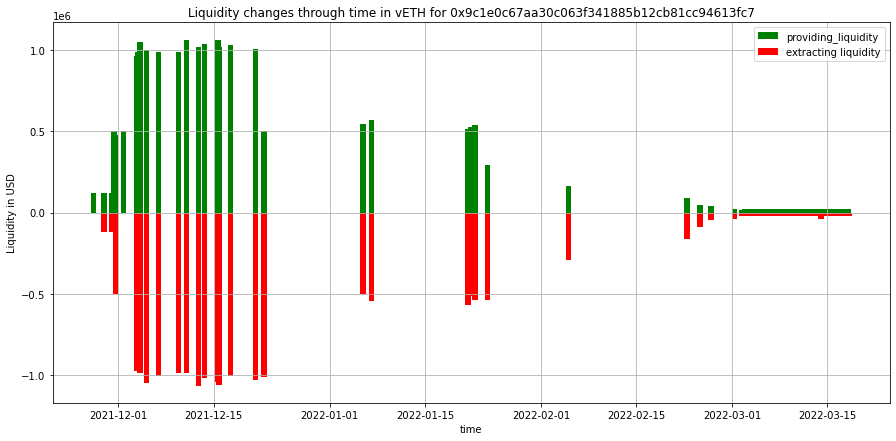

In [22]:
providing_liquidity = liquidity_changes_df[(liquidity_changes_df["fixed_liquidity"] >= 0) &
                                          (liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")]
extracting_liquidity = liquidity_changes_df[(liquidity_changes_df["fixed_liquidity"] < 0) &
                                           (liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")]

fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(providing_liquidity[providing_liquidity["pool_name"] == "vETH"]["time"], 
        providing_liquidity[providing_liquidity["pool_name"] == "vETH"]["fixed_liquidity"], 
        color='g', label='providing_liquidity')
ax.bar(extracting_liquidity[extracting_liquidity["pool_name"] == "vETH"]["time"], 
        extracting_liquidity[extracting_liquidity["pool_name"] == "vETH"]["fixed_liquidity"], 
        color='r', label='extracting liquidity')
ax.set_xlabel("time")
ax.set_ylabel("Liquidity in USD")
ax.legend()
ax.grid()
ax.set_title("Liquidity changes through time in vETH for 0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")
plt.show()

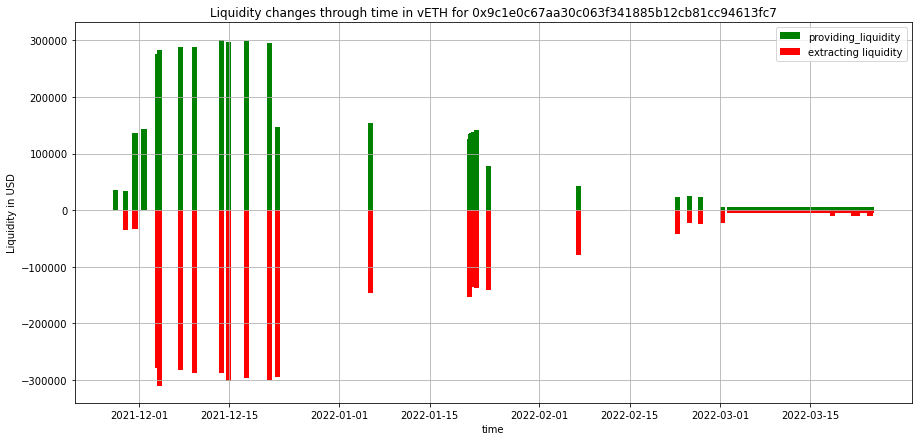

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(providing_liquidity[providing_liquidity["pool_name"] == "vBTC"]["time"], 
        providing_liquidity[providing_liquidity["pool_name"] == "vBTC"]["fixed_liquidity"], 
        color='g', label='providing_liquidity')
ax.bar(extracting_liquidity[extracting_liquidity["pool_name"] == "vBTC"]["time"], 
        extracting_liquidity[extracting_liquidity["pool_name"] == "vBTC"]["fixed_liquidity"], 
        color='r', label='extracting liquidity')
ax.set_xlabel("time")
ax.set_ylabel("Liquidity in USD")
ax.legend()
ax.grid()
ax.set_title("Liquidity changes through time in vETH for 0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")
plt.show()

# Check of the lower and upper bounds distribution referring to the token price to see maker strategy

In order to check theory that maker changes liquidity each time when price starts to go too far from the central bound and there appears a risk that it will go out of the estimated bounds, it is required to get position changes prices. First maker for who will be performed check is the one with biggest amount of collected fees

In [24]:
liquidity_changes_df[liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7"]["pool_name"].unique()

array(['vETH', 'vBTC', 'vAVAX', 'vLUNA', 'vSOL', 'vCRV'], dtype=object)

In [25]:
maker_pool_stats_df = liquidity_changes_df[liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7"
                                    ][["quote_fee", "fixed_liquidity", "pool_name"]].groupby("pool_name").sum()
maker_pool_stats_df

quote_fee  fixed_liquidity
pool_name                                
vAVAX      169697.952774     2.328306e-10
vBTC       412772.337740     9.094947e-13
vCRV       304729.082754     0.000000e+00
vETH       664285.150143    -2.328306e-10
vLUNA      217637.683087     1.047738e-09
vSOL       180665.478389     0.000000e+00

Conform presened stats can be seen that there is a need to look for ```vETH```, ```vBTC``` and ```vCRV``` pools data of the presented trader.

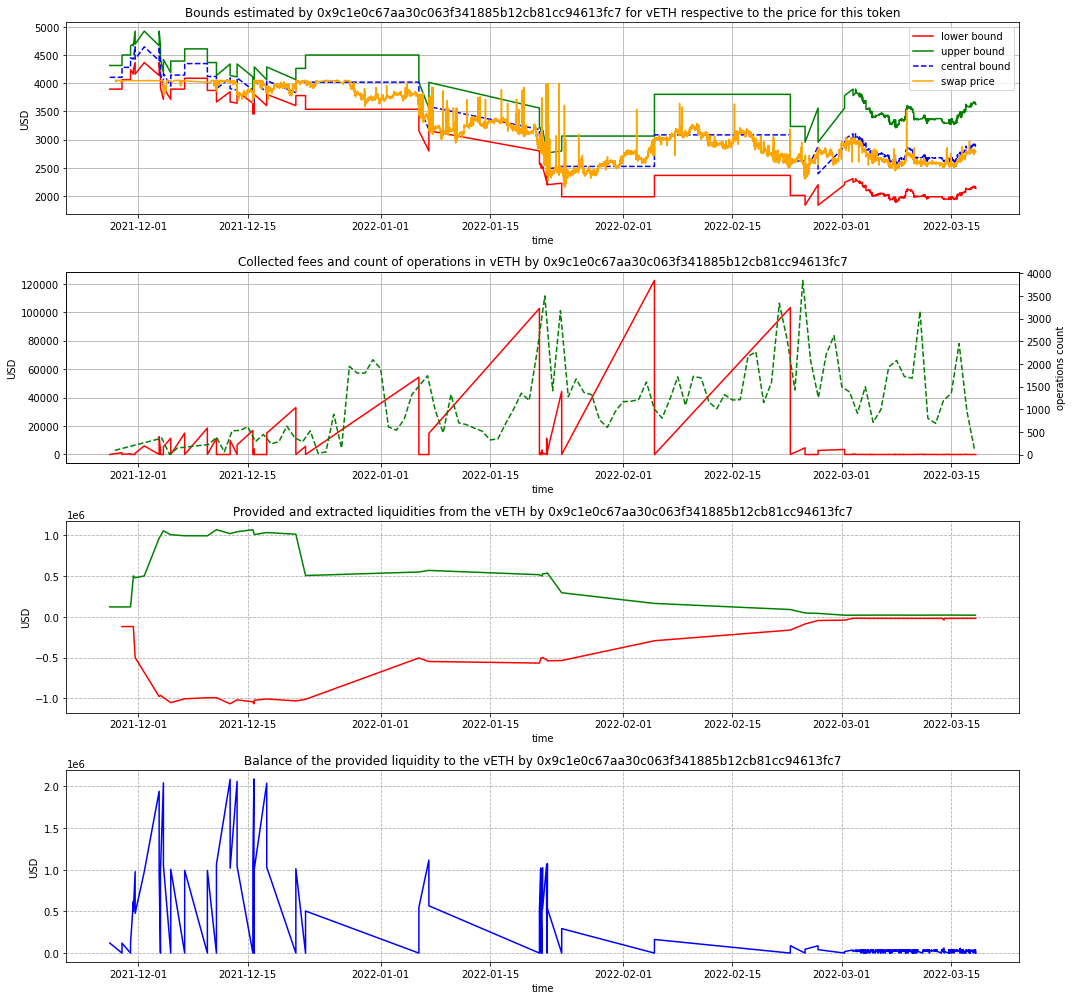

In [26]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x9c1e0c67aa30c063f341885b12cb81cc94613fc7",
                               pool_name="vETH")

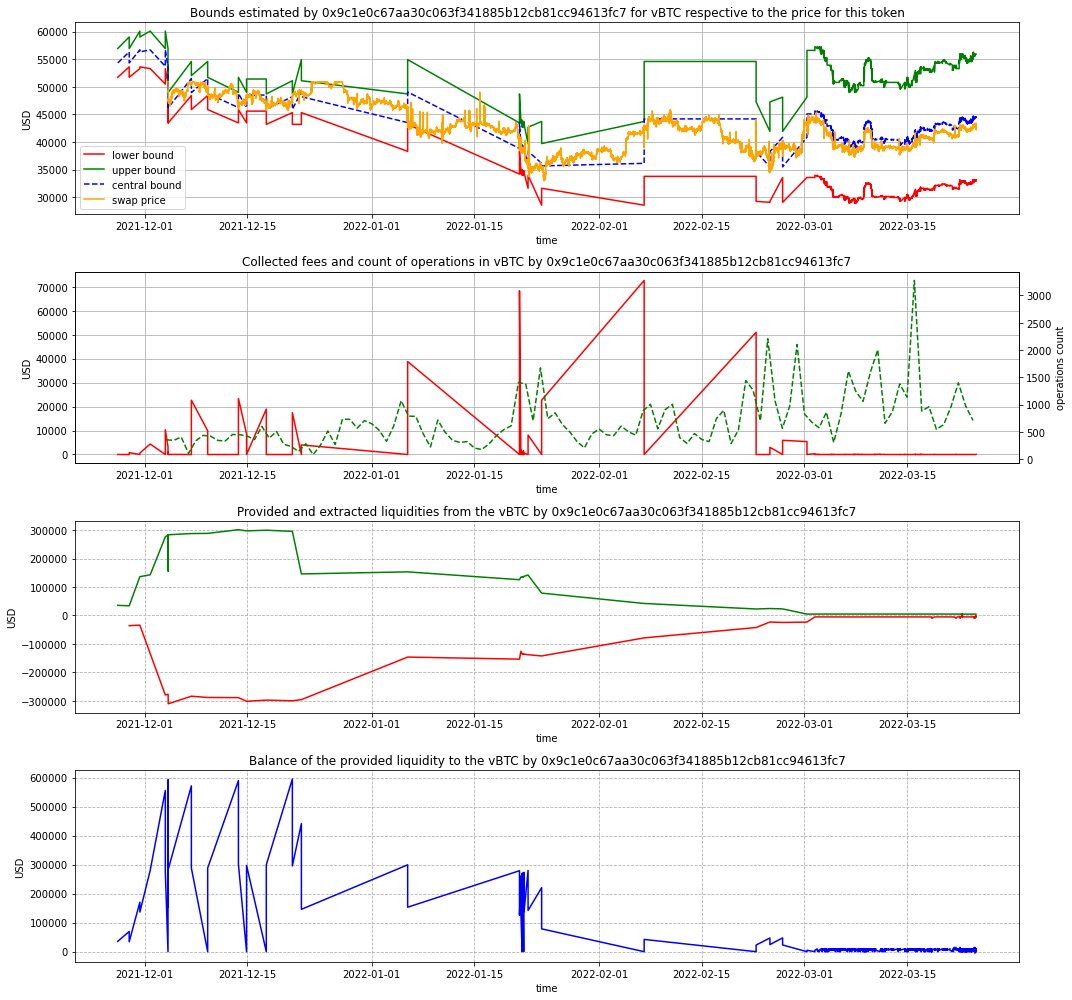

In [27]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x9c1e0c67aa30c063f341885b12cb81cc94613fc7",
                               pool_name="vBTC")

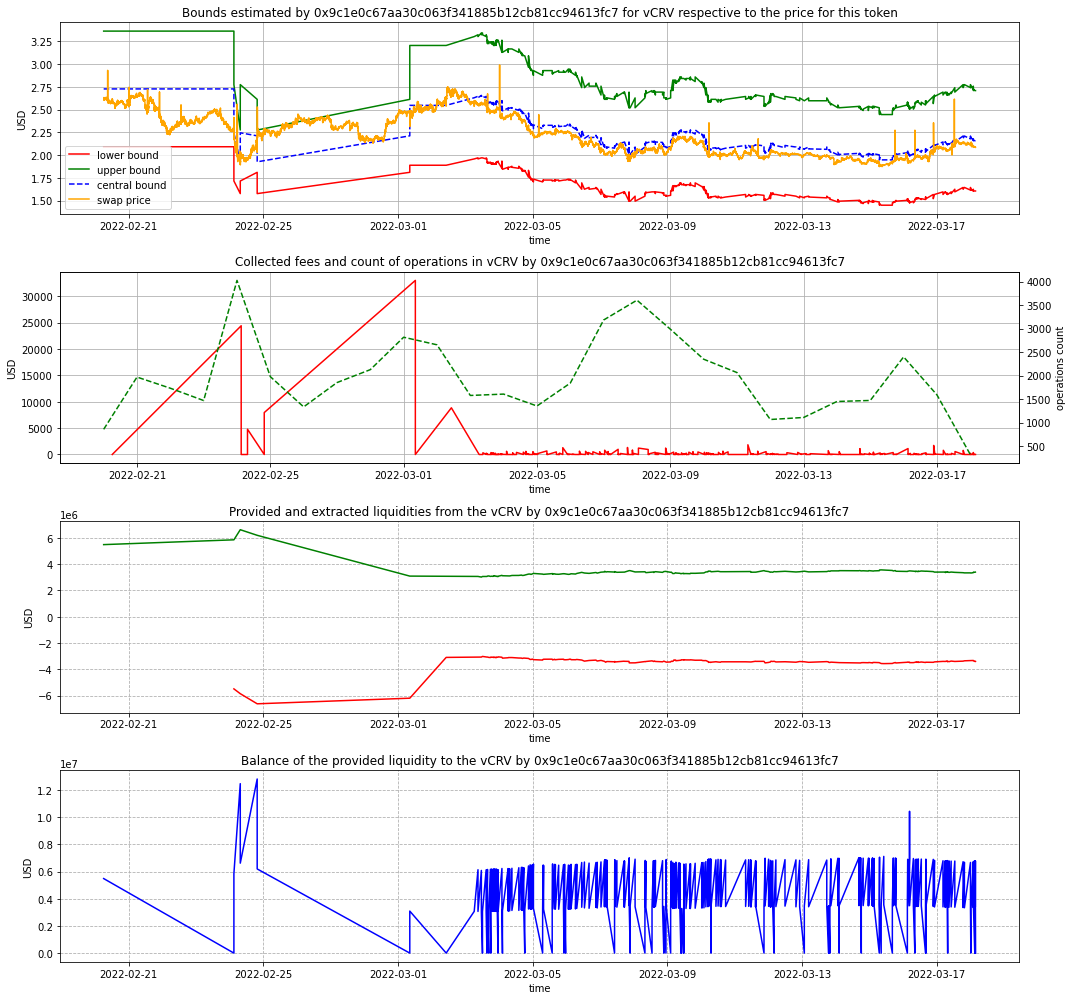

In [28]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x9c1e0c67aa30c063f341885b12cb81cc94613fc7",
                               pool_name="vCRV")

Here is another maker, leading by the number of applied liquidity changes

In [29]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0xe77dd81813bd06d74a30d1b2c07418906456498e"
                        ]["pool_name"].unique()
)

['vSAND' 'vLINK' 'vATOM']


In [30]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vSAND")

In [31]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vLINK")

In [32]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vATOM")

Based on the presented charts can be seen that makers mostly try to make price distribution to be located between bounds and therefore evade any possible impermanent loss and minimize losses. To ensure that below is reviewed the second maker by count of applied liquidity changes.

In [33]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x70332de459d5554a9a310a7c4f7c6069c73604f9"
                        ]["pool_name"].unique()
)

['vONE' 'vNEAR' 'vFTM']


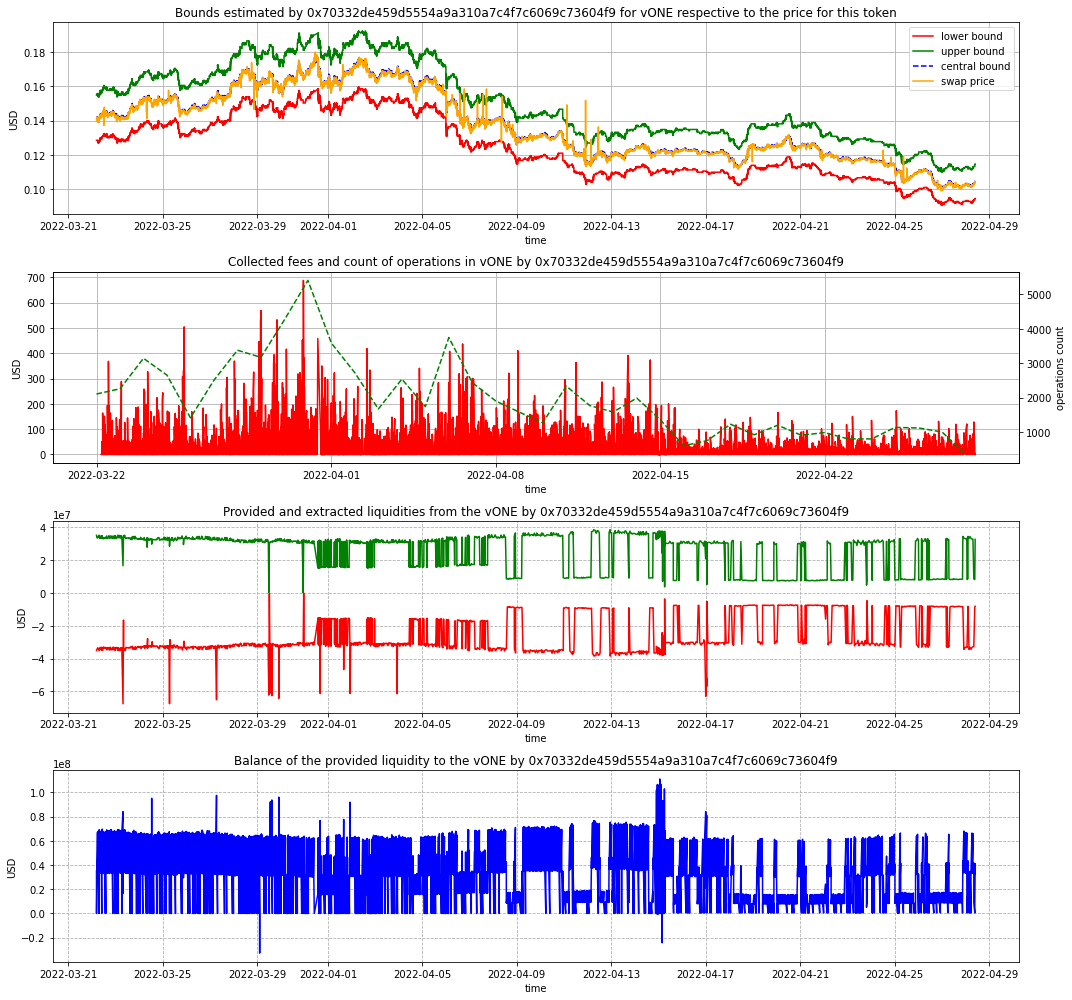

In [34]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vONE")

In [35]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vNEAR")

In [36]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vFTM")

The third address from the perspective of performed liquidity changes - ```0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be```

While other addresses demonstrate adaptive behavior with setting bounds to track swapping price in such a manner that fees will be collected as much as possible here can be seen that there applied bounds too big to be sure that price will not go out of the bounds

In [37]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be"
                        ]["pool_name"].unique()
)

['vFLOW' 'vBNB' 'vPERP']


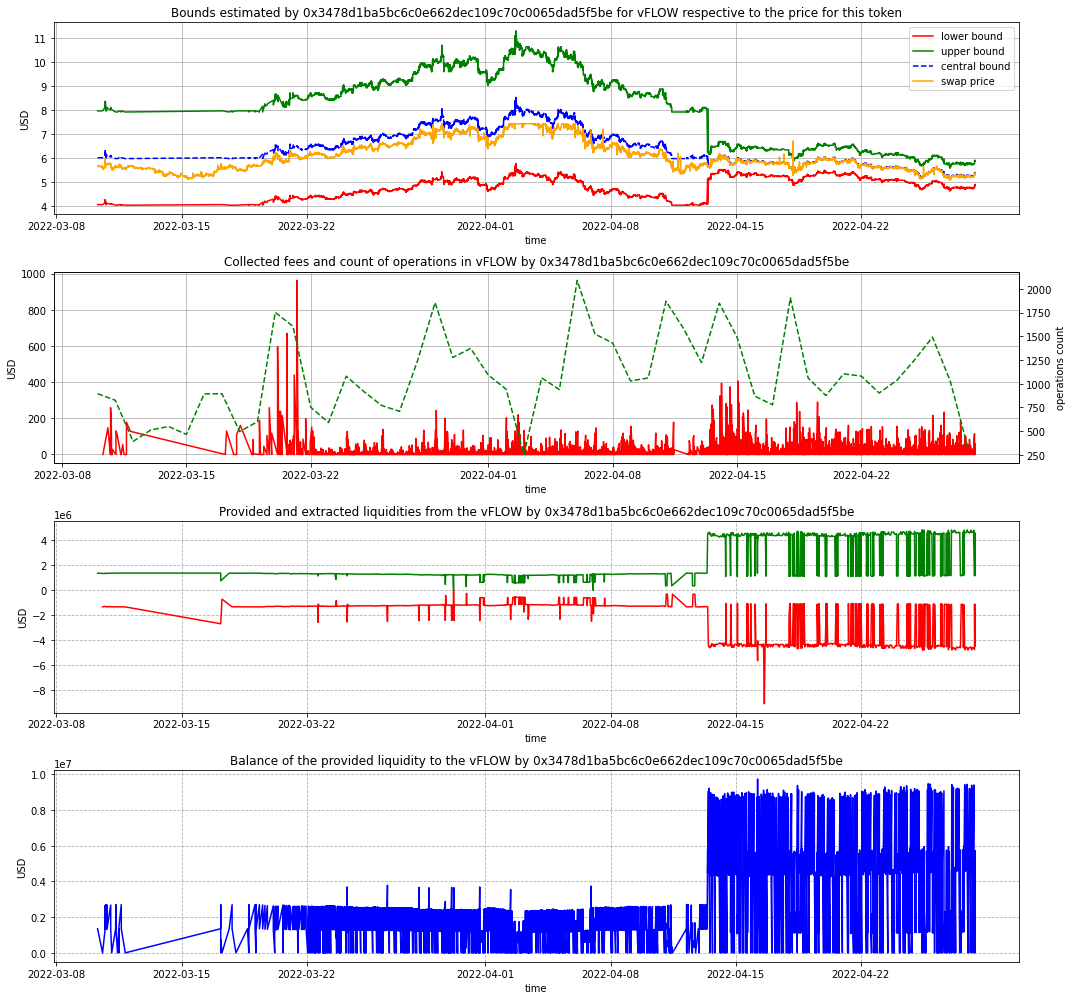

In [38]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vFLOW")

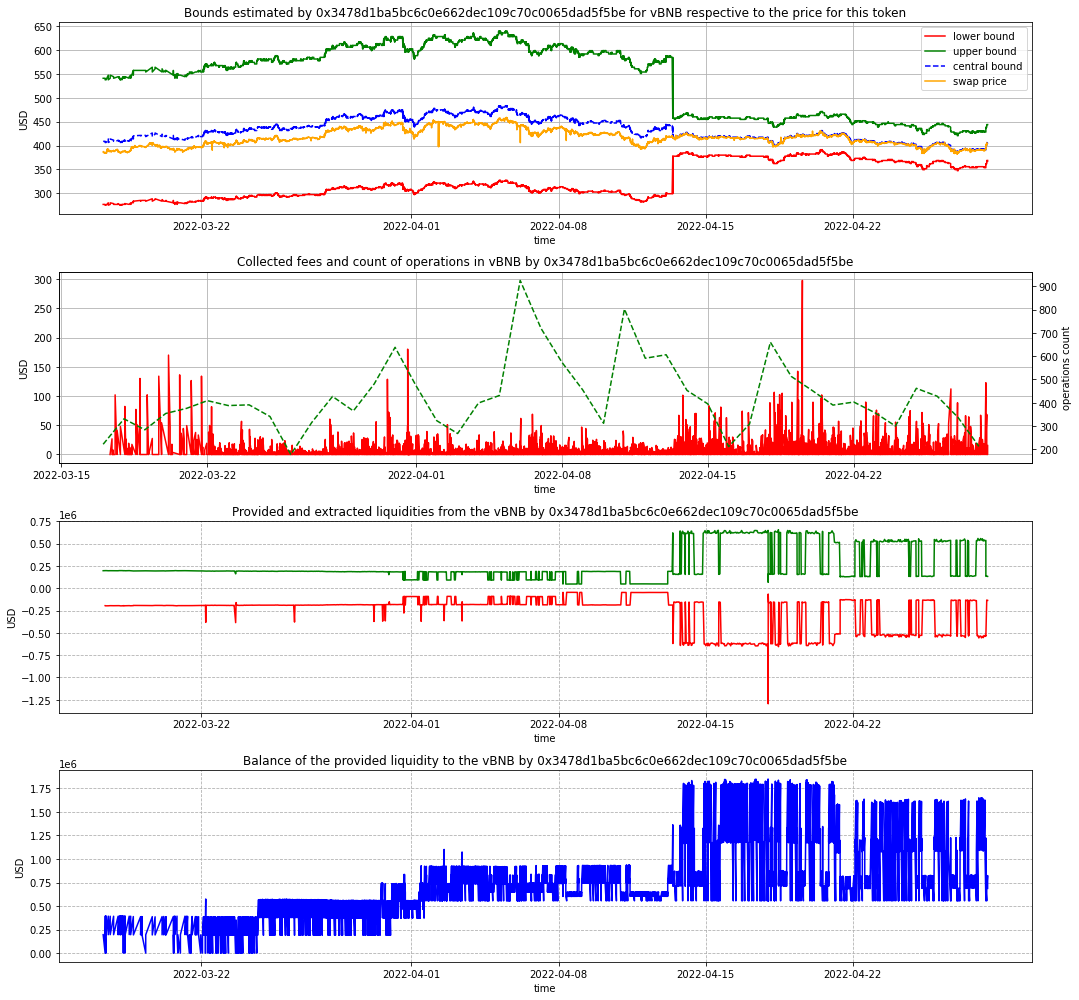

In [39]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vBNB")

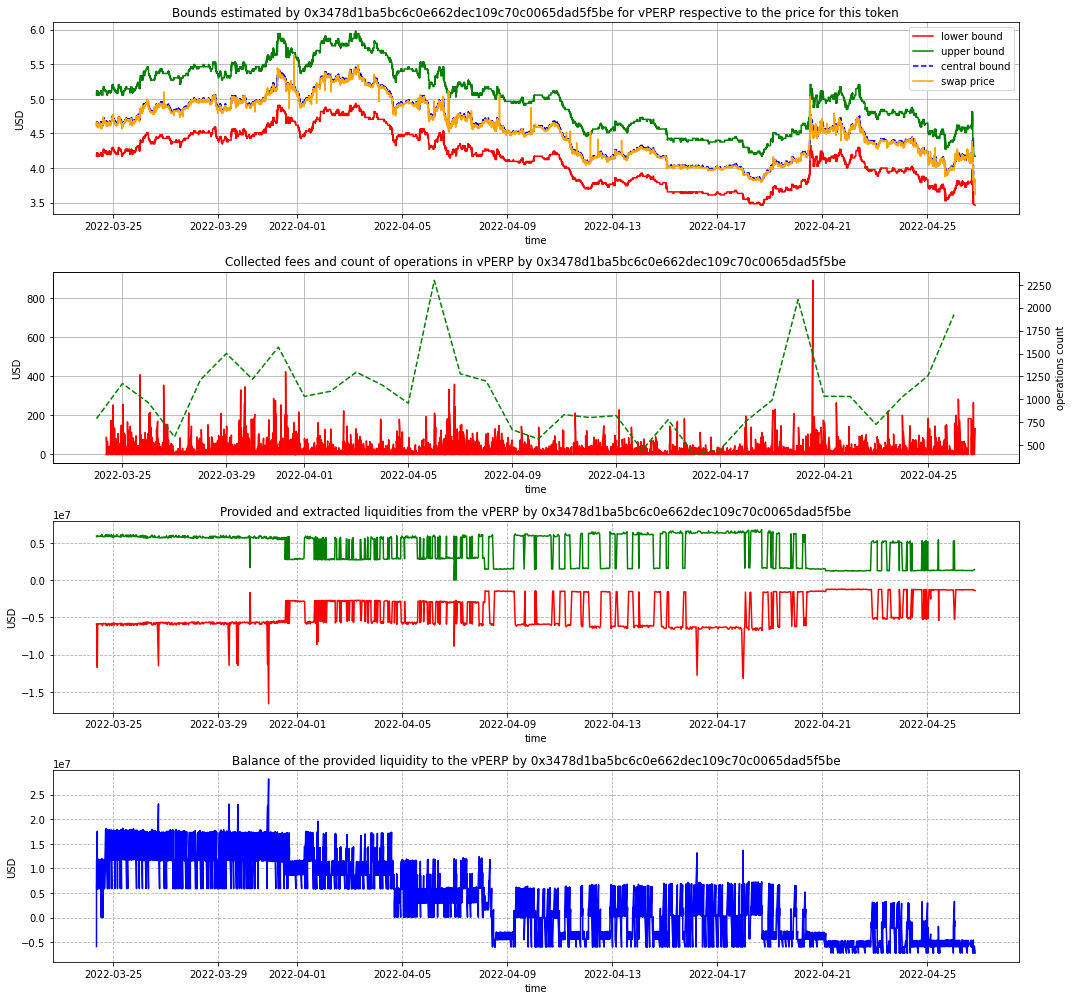

In [40]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vPERP")

The fourth address by count of applied liquidity changes - ```0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd```

In [41]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd"
                        ]["pool_name"]
    .unique()
)

['vSOL' 'vAVAX' 'vLUNA']


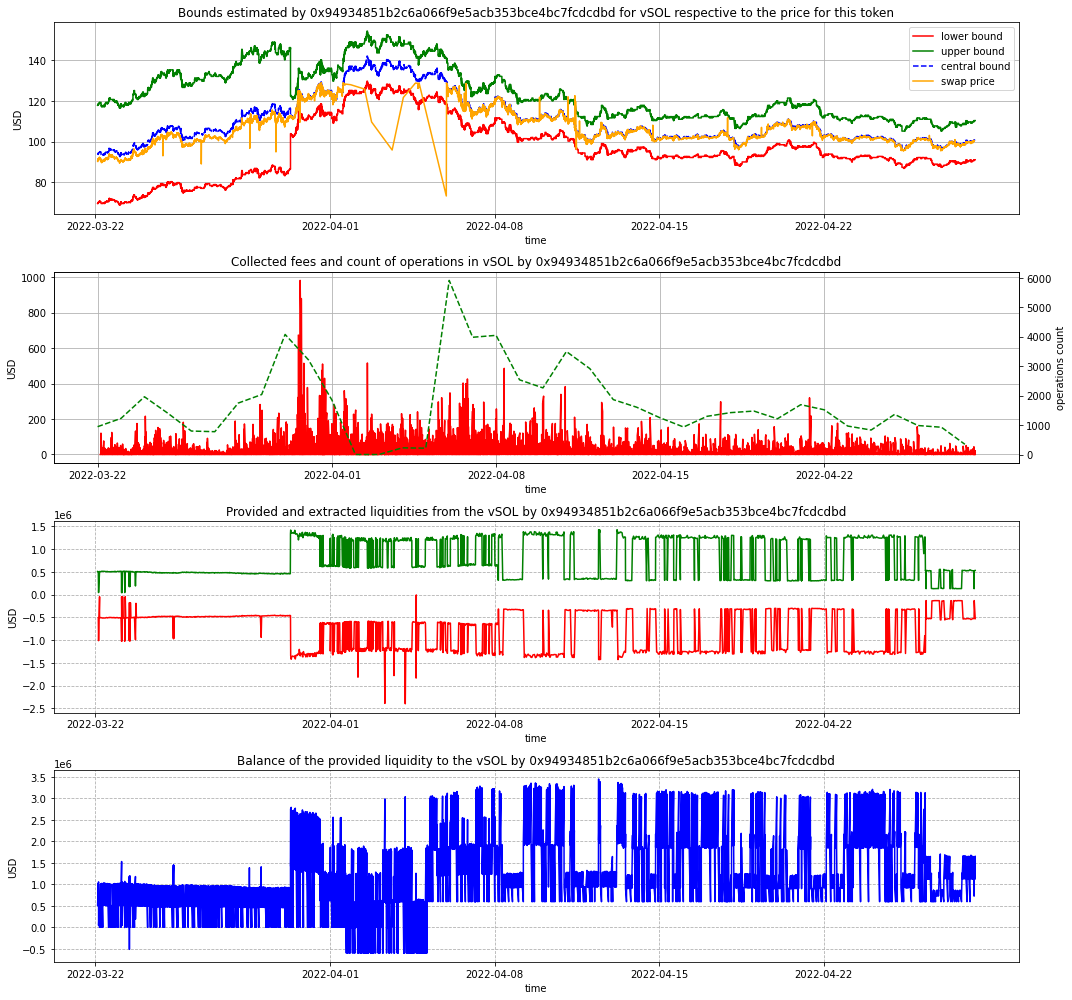

In [42]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vSOL")

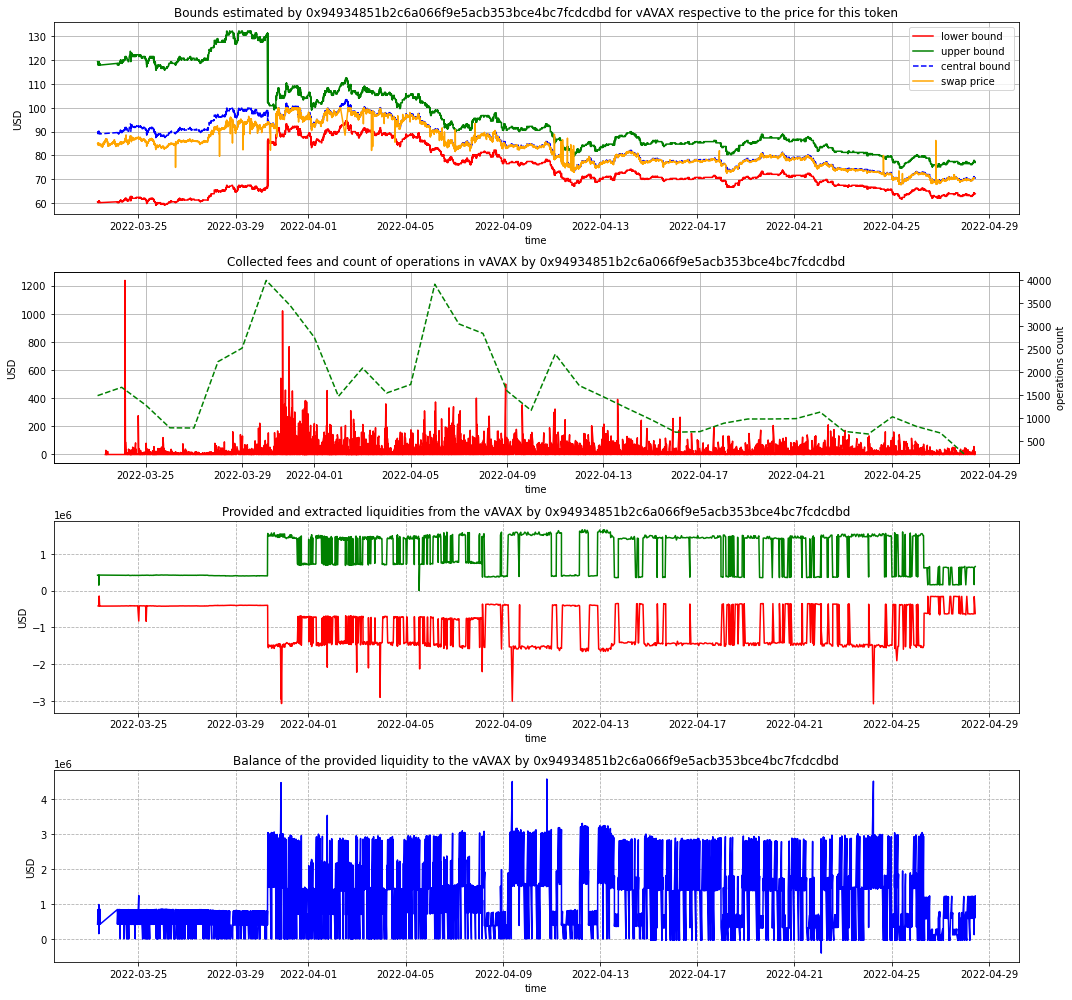

In [43]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vAVAX")

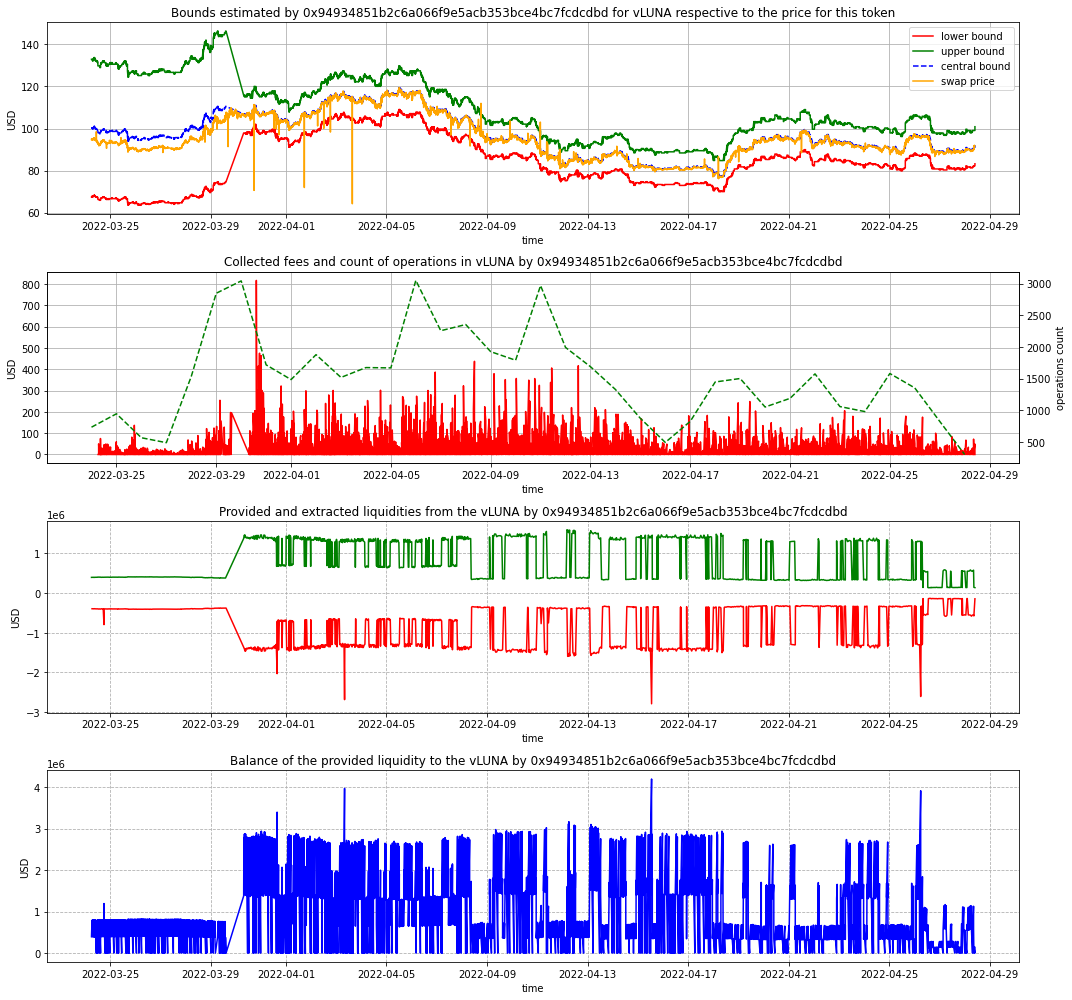

In [44]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vLUNA")

The fifth address by count of liquidity changes is ```0x675e328b73e15cd41acd2828b83b417687c36bba```

In [45]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x675e328b73e15cd41acd2828b83b417687c36bba"
                        ]["pool_name"].unique()
)

['vETH' 'vCRV' 'vBTC']


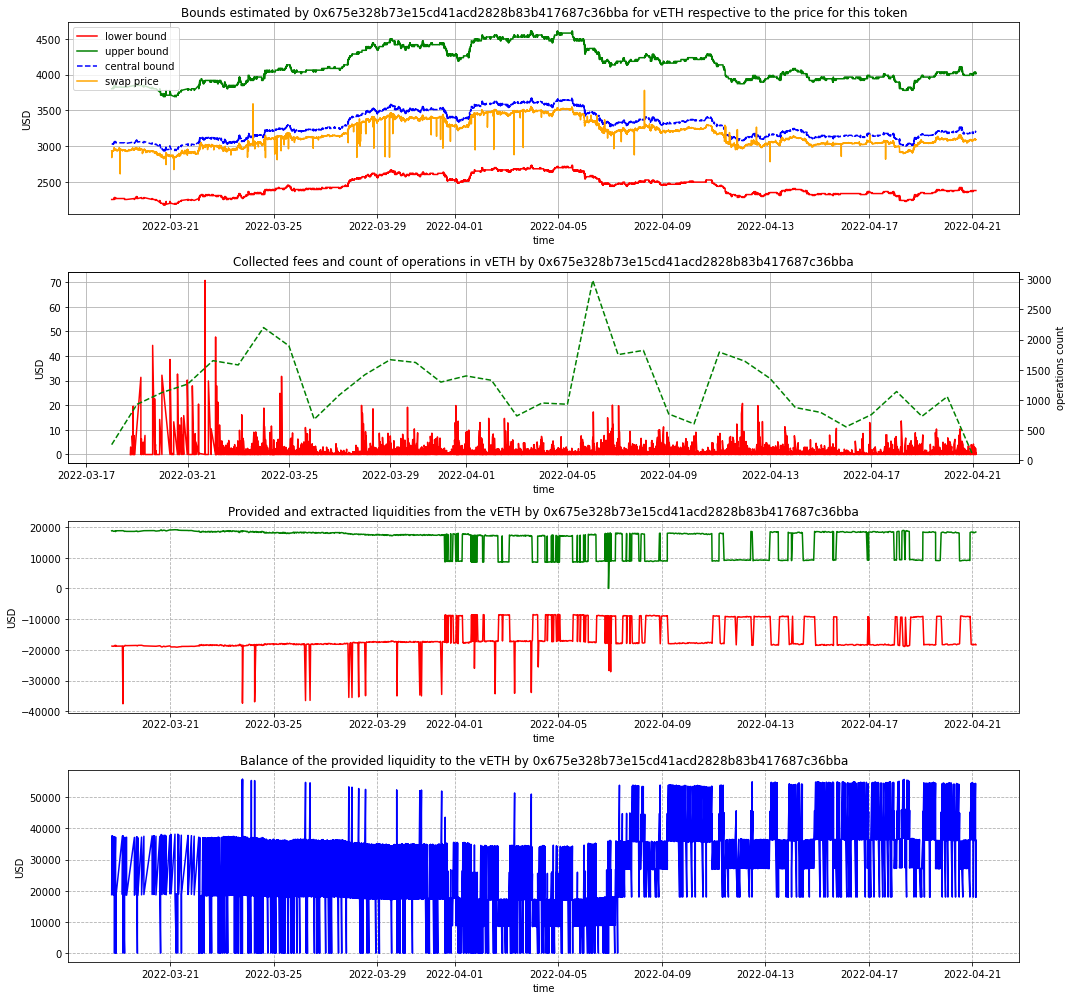

In [46]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba",
                               pool_name="vETH")

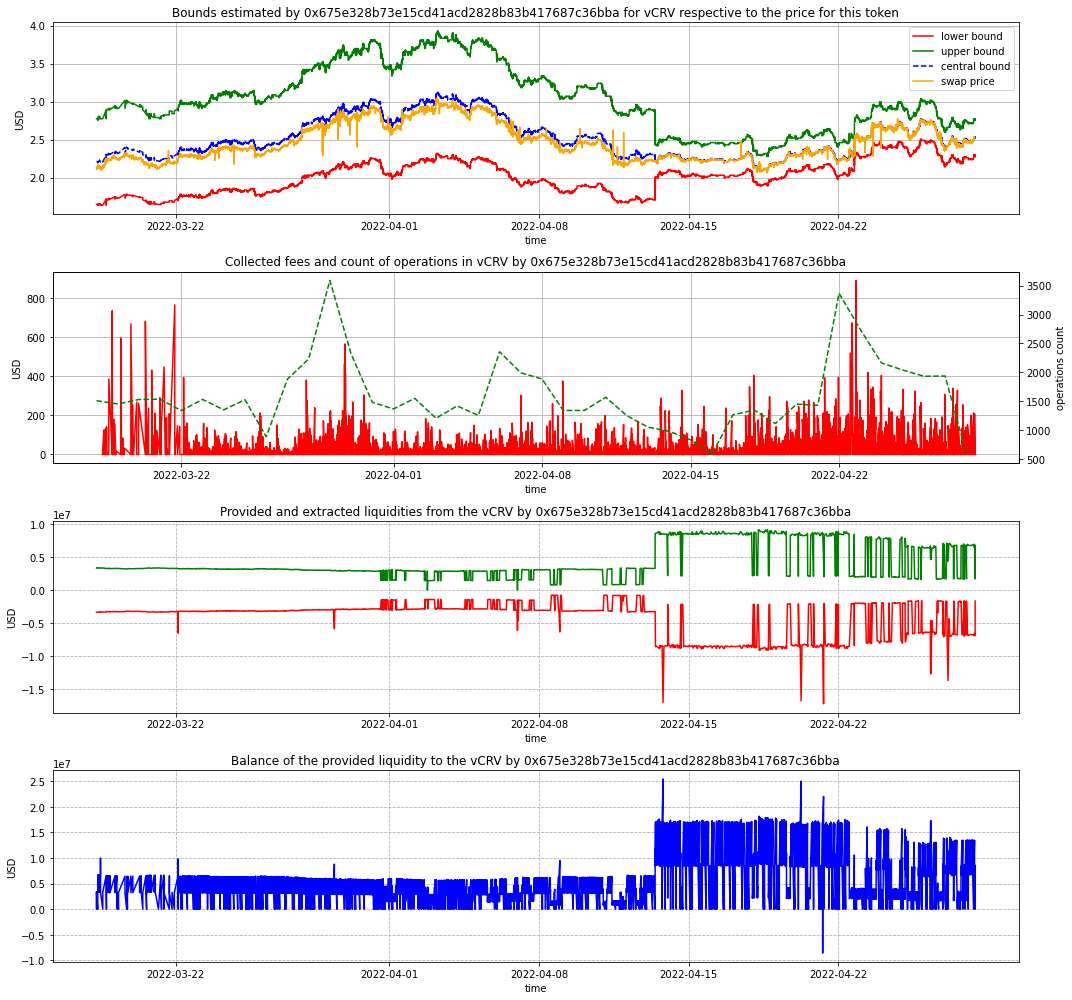

In [47]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba",
                               pool_name="vCRV")

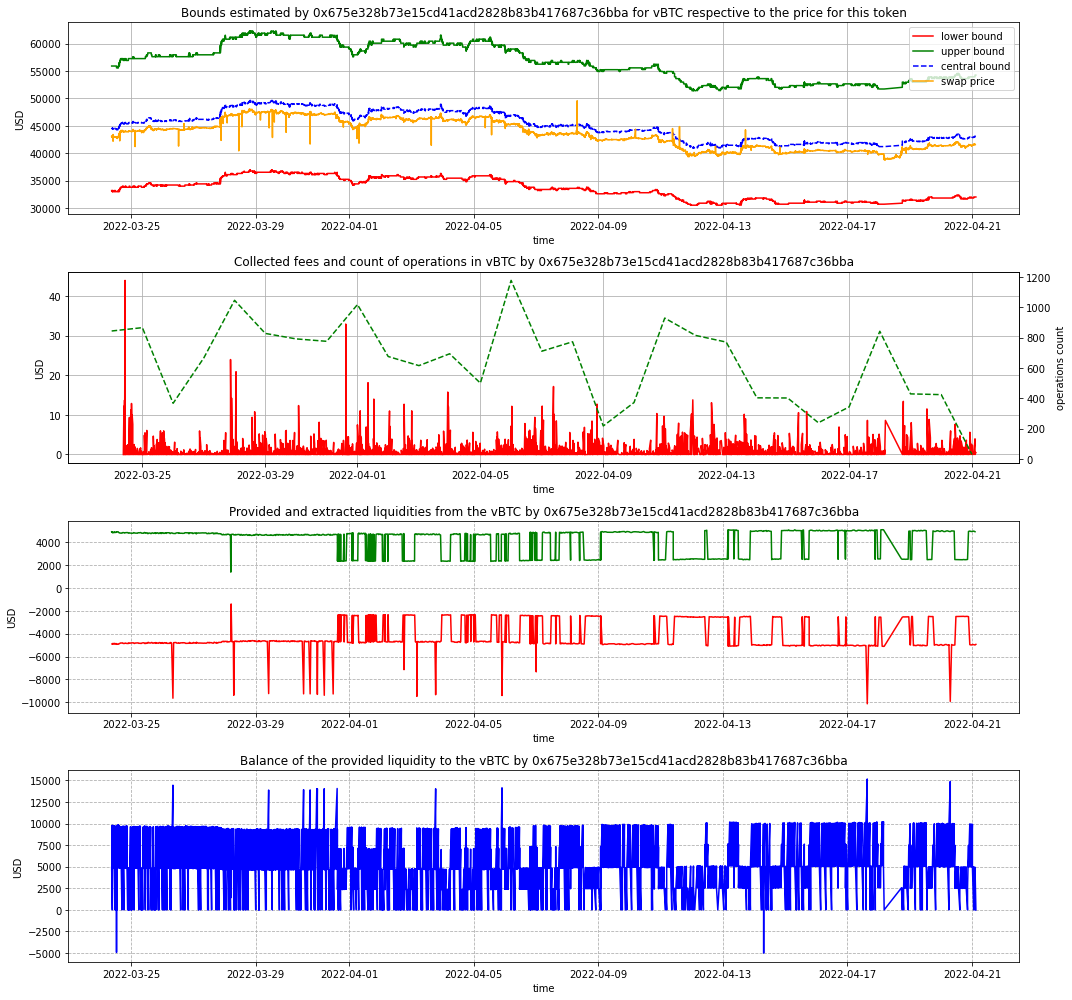

In [48]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba",
                               pool_name="vBTC")

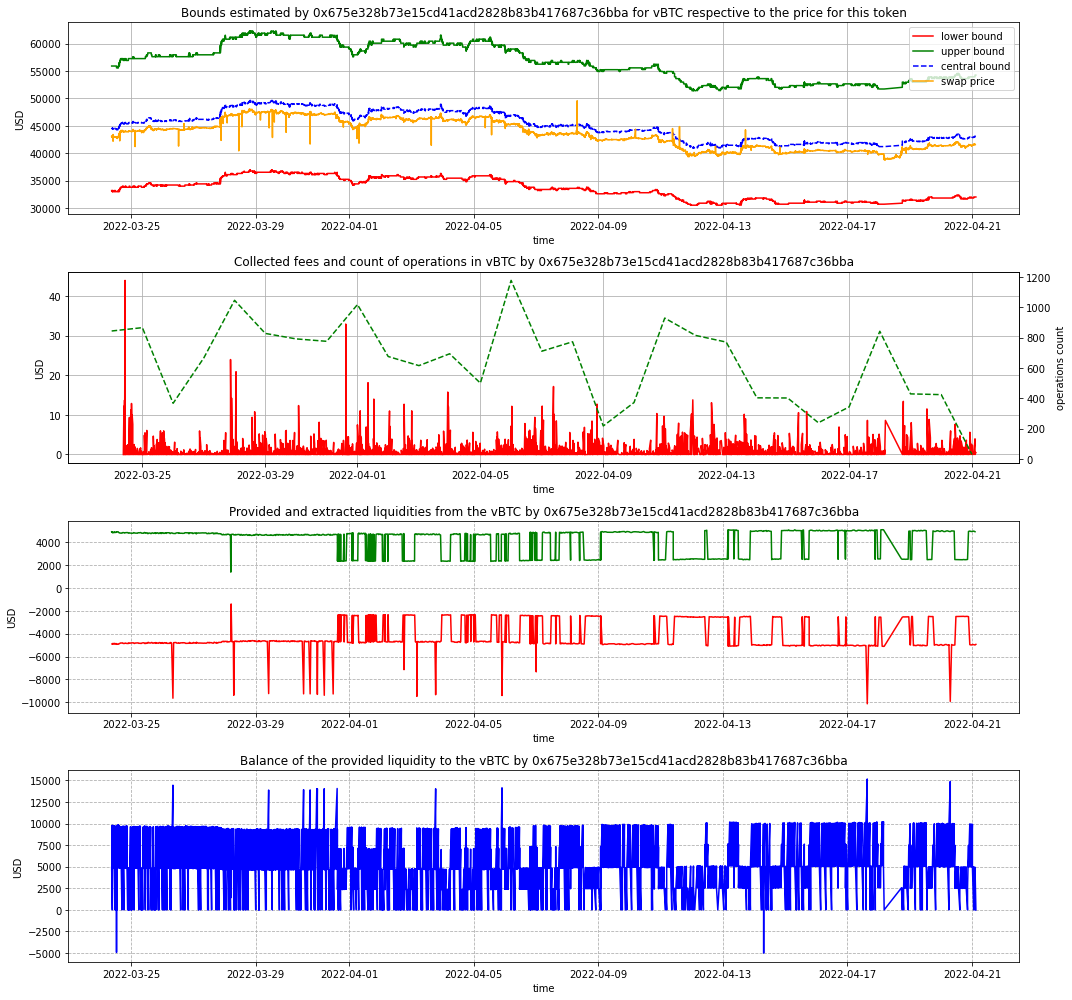

In [49]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df,
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba", 
                                pool_name='vBTC')

# Balance of the provided liquidity for each trader separately and overall

## Overall distribution

There is a need to find distribution of the overall available liquidity for each of the pools

In [50]:
maker_pool_grouped_liquidity = liquidity_changes_df[["maker", "time", "pool_name", "fixed_liquidity"]
                                 ].groupby(["pool_name", "maker", "time"]).sum()
maker_pool_grouped_liquidity = maker_pool_grouped_liquidity.reset_index()
maker_pool_grouped_liquidity.sort_values("time", inplace=True)
maker_pool_grouped_liquidity = maker_pool_grouped_liquidity.reset_index()
maker_pool_grouped_liquidity.drop(columns=["index"], inplace=True)
maker_pool_grouped_liquidity

pool_name                                       maker  \
0          vETH  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   
1          vBTC  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   
2          vETH  0x35952141922ee99a04e016c967c3f0ad589ea958   
3          vETH  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf   
4          vETH  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf   
...         ...                                         ...   
70536      vONE  0x7242eae4a7b72d60d55019234c39a6a138b12ddb   
70537      vSOL  0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd   
70538      vSOL  0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd   
70539     vSAND  0xe77dd81813bd06d74a30d1b2c07418906456498e   
70540      vFTM  0x70332de459d5554a9a310a7c4f7c6069c73604f9   

                     time  fixed_liquidity  
0     2021-11-27 08:16:25     1.208521e+05  
1     2021-11-27 08:16:25     3.564905e+04  
2     2021-11-27 09:06:32     3.863152e+02  
3     2021-11-27 10:17:13     3.731414e+02  
4     2021-11-27 11:29:01    -3.731414e+02  
...                   ...              ...  
70536 2022-04-28 10:31:56     6.543434e+03  
70537 2022-04-28 10:34:02     5.322407e+05  
70538 2022-04-28 10:34:19    -5.283875e+05  
70539 2022-04-28 10:36:10    -4.863709e+06  
70540 2022-04-28 10:43:27    -3.600007e+04  

[70541 rows x 4 columns]

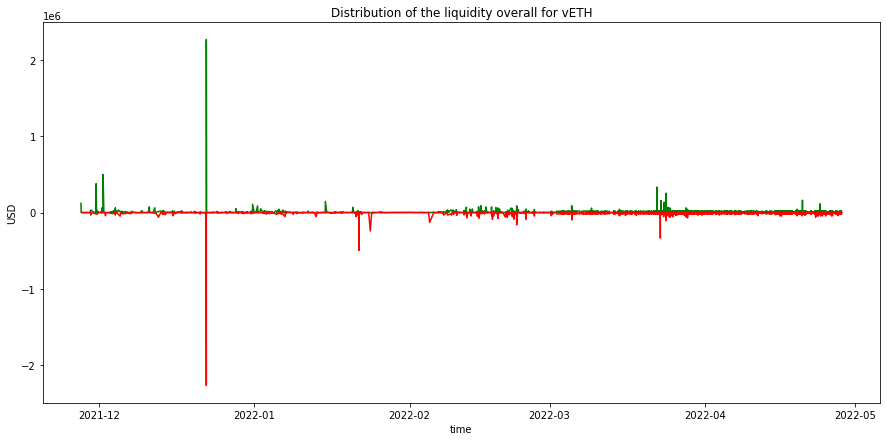

In [51]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
pool_liquidity_movement = maker_pool_grouped_liquidity[maker_pool_grouped_liquidity["pool_name"] == "vETH"]

ax.plot(pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] >= 0]["time"],
       pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] >= 0]["fixed_liquidity"],
       color='g', label='investments')
ax.plot(pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] < 0]["time"],
       pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] < 0]["fixed_liquidity"],
       color='r', label='extractions')
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.set_title("Distribution of the liquidity overall for vETH")
plt.show()

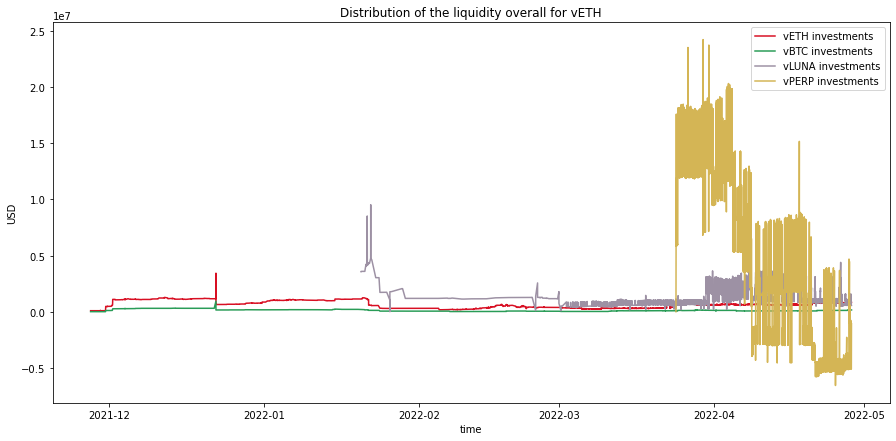

In [52]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for pool in ["vETH", "vBTC", "vLUNA", "vPERP"]:
    col = (np.random.random(), np.random.random(), np.random.random())
    pool_liquidity_movement = maker_pool_grouped_liquidity[maker_pool_grouped_liquidity["pool_name"] == pool]
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement["time"], pool_liquidity_movement["liquidity_balance"],
            color=col, label=pool+' investments')
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.set_title("Distribution of the liquidity overall for vETH")
plt.show()

## Liquidity over time with daily results

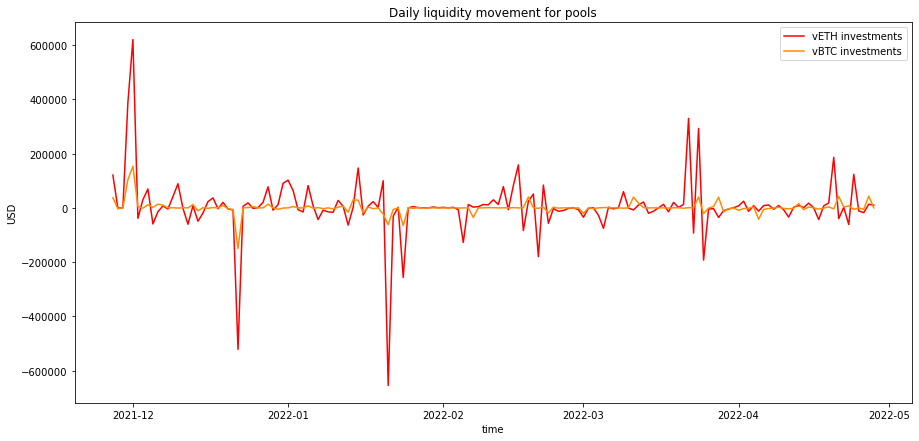

In [67]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vETH", "vBTC"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    daily_liquidity_movement = pool_liquidity_movement.resample("D").sum()
    ax.plot(daily_liquidity_movement.index, daily_liquidity_movement["fixed_liquidity"],
            color=colors[color_index], label=pool+' investments')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.set_title("Daily liquidity movement for pools")
plt.show()

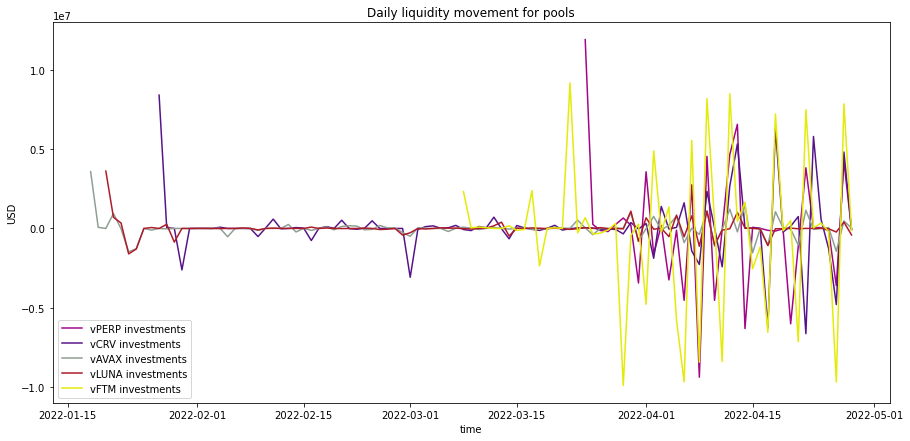

In [54]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for pool in ["vPERP", "vCRV", "vAVAX", "vLUNA", "vFTM"]:
    col = (np.random.random(), np.random.random(), np.random.random())
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    daily_liquidity_movement = pool_liquidity_movement.resample("D").sum()
    ax.plot(daily_liquidity_movement.index, daily_liquidity_movement["fixed_liquidity"],
            color=col, label=pool+' investments')
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.set_title("Daily liquidity movement for pools")
plt.show()

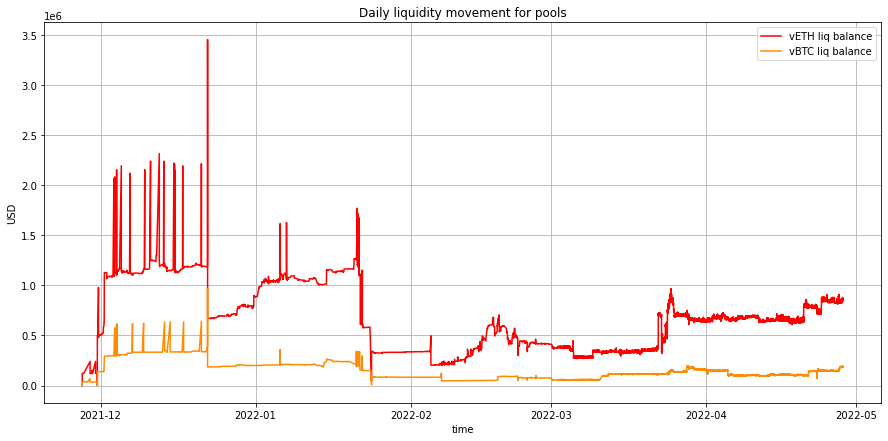

In [64]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vETH", "vBTC"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement.index, pool_liquidity_movement["liquidity_balance"],
            color=colors[color_index], label=pool+' liq balance')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.grid()
ax.set_title("Daily liquidity movement for pools")
plt.show()

In case of taking a cumulative sum there is a very strange distribution. So, there are two aspects that should most likely be verified:

1. Here was performed sort of the records conform their timestamp, but there are also block numbers with internal indexes, meaning that application of sort with this approach will give better results;
2. There can be made estimation of either mean balance values per day, or estimation of the balance at the end of day

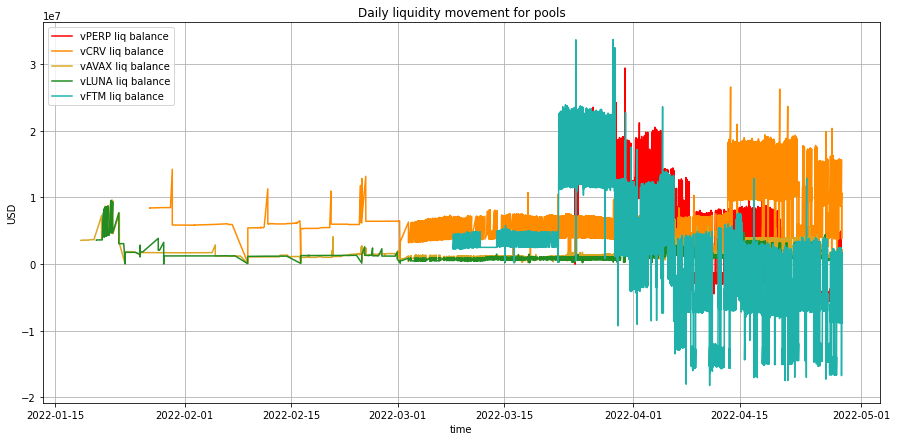

In [65]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vPERP", "vCRV", "vAVAX", "vLUNA", "vFTM"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement.index, pool_liquidity_movement["liquidity_balance"],
            color=colors[color_index], label=pool+' liq balance')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.grid()
ax.set_title("Daily liquidity movement for pools")
plt.show()

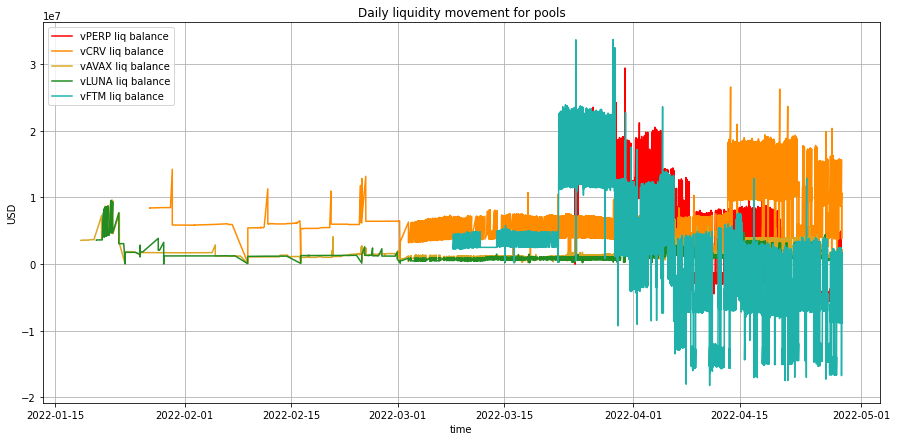

In [66]:
liquidity_changes_df.sort_values("block_number_log_index", inplace=True)
liquidity_changes_df = liquidity_changes_df.reset_index()
liquidity_changes_df.drop(columns=["index"], inplace=True)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vPERP", "vCRV", "vAVAX", "vLUNA", "vFTM"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement.index, pool_liquidity_movement["liquidity_balance"],
            color=colors[color_index], label=pool+' liq balance')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.grid()
ax.set_title("Daily liquidity movement for pools")
plt.show()